# Fatty Liver Disease (FLD) Study

- alcoholic vs non-alcoholic FLD, short: AFLD vs NAFLD


**Outline**

1. Study on liver disease types:
    1. Fibrosis
    1. Steatosis
    2. Inflammation
    
2. Two data sets with 
    1. clinical markers
    2. proteome information

In [1]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH').split(';'))

PYTHONPATH: None
PATH: ['C:\\Users\\Henry\\.conda\\envs\\ald_study', 'C:\\Users\\Henry\\.conda\\envs\\ald_study\\Library\\mingw-w64\\bin', 'C:\\Users\\Henry\\.conda\\envs\\ald_study\\Library\\usr\\bin', 'C:\\Users\\Henry\\.conda\\envs\\ald_study\\Library\\bin', 'C:\\Users\\Henry\\.conda\\envs\\ald_study\\Scripts', 'C:\\Users\\Henry\\.conda\\envs\\ald_study\\bin', 'C:\\ProgramData\\Miniconda3', 'C:\\ProgramData\\Miniconda3\\Library\\mingw-w64\\bin', 'C:\\ProgramData\\Miniconda3\\Library\\usr\\bin', 'C:\\ProgramData\\Miniconda3\\Library\\bin', 'C:\\ProgramData\\Miniconda3\\Scripts', 'C:\\ProgramData\\Miniconda3\\bin', 'C:\\ProgramData\\Miniconda3\\condabin', 'C:\\ProgramData\\Miniconda3', 'C:\\ProgramData\\Miniconda3\\Library\\mingw-w64\\bin', 'C:\\ProgramData\\Miniconda3\\Library\\usr\\bin', 'C:\\ProgramData\\Miniconda3\\Library\\bin', 'C:\\ProgramData\\Miniconda3\\Scripts', 'C:\\Windows\\system32', 'C:\\Windows', 'C:\\Windows\\System32\\Wbem', 'C:\\Windows\\System32\\WindowsPowerShell\

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model as skllm
import sklearn.ensemble as skle

import sklearn.metrics as sklm
import sklearn.model_selection as sklms
from sklearn.model_selection import cross_val_predict

import ipywidgets as widgets
import tqdm

In [3]:
import src
import src.utils as utils

In [4]:
import os
CPUS = os.cpu_count()
RANDOMSTATE = 29

FOLDER_DATA_RAW = 'data/raw'
DATAFOLDER = 'data/processed'
os.makedirs('data/processed', exist_ok=True)
TABLEFOLDER = 'tables'
RESULT_FOLDER = 'results'

# Explore datasets

Diagnostic comparators (existing best-in-class) biomarkers
- Fibrosis markers: transient elastography, 2-dimensional shear wave elastography, ELF test, FibroTest, FIB4 score, APRI score, Forns score, ProC3
- Inflammation markers: M30=caspase-cleaved cytokeratin-18 fragments, M65=total CK18, AST:ALT ratio, ProC3
- Steatosis: Controlled attenuation parameter

In [5]:
pd.set_option('max_columns', 9)

_folder = FOLDER_DATA_RAW
_index_col = 'Sample ID'

files = [file for file in os.listdir(_folder) if '.csv' in file]

if not files:
    print("No processed files found.")
else:
    w_data = widgets.Dropdown(options=files)

    # # Possible Alternative for DropDown 
    # from src.widgets import multi_checkbox_widget
    show_data = src.widgets.create_show_data(index_col=_index_col, datafolder=_folder)
    out = widgets.interactive_output(show_data, controls={'file':w_data})

    data = show_data.__closure__[0].cell_contents
    w_cols = widgets.SelectMultiple(options=list(data.columns))

    show_selected_proteins = src.widgets.create_show_selected_proteins(data=data)

    out_sel = widgets.interactive_output(show_selected_proteins, {'columns': w_cols})
    out_sel = widgets.interactive_output(show_selected_proteins, {'columns': w_cols})

    # Updater
    def widget_updater(other_widget):
        """Picks first element from closure. other_widget is not used directly"""
        data = show_data.__closure__[0].cell_contents
        w_cols.options = list(data.columns)
        show_selected_proteins.__closure__[0].cell_contents = data

    _ = widgets.interactive_output(widget_updater, {'other_widget': w_data})

    display(widgets.VBox([w_data, out, w_cols, out_sel]))

## Proteomics data

### Load Complete proteomics data

Full preprocessing pipeline

In [6]:
annotation_file = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'Experiment annotation file.csv'), index_col = [0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_plasma.index = pd.Index(annotation_file_plasma.index, dtype=int)
display(annotation_file_plasma.head())
annotation_file_plasma.describe()

,File name,Sample ID,Groups,Species,Group2,Sample type
0,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A1,QC,Human,QC,Plasma
1,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A2,HP,Human,HP,Plasma
2,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A3,HP,Human,HP,Plasma
3,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A4,ALD,Human,ALD,Plasma
4,[5] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A5,ALD,Human,ALD,Plasma


,File name,Sample ID,Groups,Species,Group2,Sample type
count,603,603,603,603,603,603
unique,603,603,4,1,3,1
top,[295] 20190528_QE10_Evosep1_P0000005_LiNi_SA_P...,Plate1_E1,ALD,Human,ALD,Plasma
freq,1,1,355,603,459,603


The annotation file holds the filename for the the processed raw data by Skyline and some annotation, e.g. the `Sample ID`

In [7]:
annotation_file_plasma["Sample ID"]

0       Plate1_A1
1       Plate1_A2
2       Plate1_A3
3       Plate1_A4
4       Plate1_A5
          ...    
598    Plate7_C10
599    Plate7_C11
600    Plate7_C12
601     Plate7_D1
602     Plate7_D2
Name: Sample ID, Length: 603, dtype: object

The mapping for Protein ID to the gene ID is given by `report_plasma`

In [8]:
report_plasma = pd.read_csv(os.path.join(FOLDER_DATA_RAW, '20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv'), na_values='Filtered')
report_plasma.rename({'PG.Genes': 'Gene names', 'PG.ProteinAccessions': 'Protein ID'}, inplace= True, axis=1)
report_plasma.head() 

,Protein ID,Gene names,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A1.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A2.htrms.PG.NrOfStrippedSequencesUsedForQuantification,...,[600] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C11.htrms.PG.Quantity,[601] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C12.htrms.PG.Quantity,[602] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D1.htrms.PG.Quantity,[603] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D2.htrms.PG.Quantity
0,A0A024R6I7,SERPINA1,1.0,1.0,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
1,A0A075B6I0,IGLV8-61,1.0,1.0,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
2,A0A075B6J9,IGLV2-18,1.0,1.0,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
3,A0A075B6R9;A0A0C4DH68,IGKV2D-24;IGKV2-24,1.0,1.0,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
4,A0A075B6S2;A2NJV5,IGKV2D-29;IGKV2-29,1.0,1.0,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06


Create mapping object (see if proteins are unique -> get function from other project)

In [9]:
columns_ = ['Protein ID', 'Gene names']
ids_ = report_plasma[columns_].apply(lambda series_: series_.str.split(';'))
ids_.head()

,Protein ID,Gene names
0,[A0A024R6I7],[SERPINA1]
1,[A0A075B6I0],[IGLV8-61]
2,[A0A075B6J9],[IGLV2-18]
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"


In [10]:
def length_(x):
    try:
        return len(x)
    except:
        return 0
    
count_groups_proteins = ids_.apply(lambda series_: series_.apply(length_))
count_groups_proteins

,Protein ID,Gene names
0,1,1
1,1,1
2,1,1
3,2,2
4,2,2
...,...,...
519,1,1
520,1,1
521,1,1
522,1,1


In [11]:
src.utils.compare_count(count_groups_proteins, *columns_)

,Protein ID,Gene names
value counts,,
0,NaN,2.0
1,318.0,499.0
2,121.0,11.0
3,44.0,3.0
4,20.0,2.0
5,7.0,3.0
6,6.0,1.0
7,1.0,NaN
8,1.0,NaN


- Protein IDs are always set
- two proteins have no annotations (Gene name count of 0 appears twice)
- the are some protein names which are mapped to the same gene. 
Let have a look at cases where a set of proteins was not mapped uniquely to one gene:

In [12]:
ids_.loc[count_groups_proteins['Gene names'] != 1]

,Protein ID,Gene names
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"
8,"[A0A087WWU8, P06753-2, Q5HYB6]","[TPM3, TPM3, DKFZp686J1372]"
21,"[A0A0A0MRZ8, P04433]","[IGKV3D-11, IGKV3-11]"
36,"[A0A0C4DH43, A0A0J9YVU5]","[IGHV2-70D, IGHV2-70]"
37,"[A0A0C4DH72, P01599]","[IGKV1-6, IGKV1-17]"
40,"[A0A0G2JIW1, P0DMV8, P0DMV9]","[HSPA1B, HSPA1A, HSPA1B]"
44,"[A0A0J9YY99, P01764, P01768, P0DP03]","[, IGHV3-23, IGHV3-30, IGHV3-30-5]"
48,"[A0A0U1RR32, A0A0U1RRH7, P04908, P0C0S8, P2067...","[HIST1H3D, HIST1H3D, HIST1H2AB, HIST1H2AG, HIS..."
70,"[B4DV12, F5GXK7, F5GYU3, F5H265, F5H2Z3, F5H38...","[UBB, UBC, UBC, UBC, UBC, UBC, UBC, UBC, UBB, ..."


In [13]:
from src.imputation import imputation_normal_distribution, log2, NP_LOG_FCT, IMPUTATION_MEAN_SHIFT, IMPUTATION_STD_SHRINKAGE
#imputation_normal_distribution??

In [14]:
# Report_plasma = pd.read_csv('raw/proteomics/plasma/20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv')
experimental_columns = annotation_file_plasma['Sample ID']
report_plasma[columns_] = report_plasma[columns_].apply(lambda series_: series_.str.split(';').str[0])

In [15]:
report_plasma.describe()

,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A1.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A2.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A3.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A4.htrms.PG.NrOfStrippedSequencesUsedForQuantification,...,[600] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C11.htrms.PG.Quantity,[601] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C12.htrms.PG.Quantity,[602] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D1.htrms.PG.Quantity,[603] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D2.htrms.PG.Quantity
count,361.000000,327.000000,317.000000,340.000000,...,3.640000e+02,3.200000e+02,3.130000e+02,3.220000e+02
mean,2.124654,2.171254,2.192429,2.191176,...,3.939520e+06,4.541551e+06,4.727407e+06,4.267386e+06
std,0.933022,0.927444,0.912747,0.903245,...,4.108969e+07,4.513567e+07,4.711617e+07,4.104998e+07
min,1.000000,1.000000,1.000000,1.000000,...,1.908130e+02,5.826772e+02,7.995712e+02,2.039593e+02
25%,1.000000,1.000000,1.000000,1.000000,...,8.566062e+03,1.047221e+04,1.268499e+04,1.084710e+04
50%,3.000000,3.000000,3.000000,3.000000,...,4.154654e+04,6.404788e+04,6.787159e+04,6.053365e+04
75%,3.000000,3.000000,3.000000,3.000000,...,4.774295e+05,6.070775e+05,7.744870e+05,6.438288e+05
max,3.000000,3.000000,3.000000,3.000000,...,7.727070e+08,7.973126e+08,8.239611e+08,7.269720e+08


In [16]:
map_filenames_ids = dict(zip(annotation_file['File name'], annotation_file['Sample ID']))

Remove some measurements which are not intensities, but ... ?

In [17]:
data_plasma_raw = report_plasma.copy()
data_plasma_raw.drop(data_plasma_raw.filter(regex='StrippedSequences').columns, axis=1, inplace = True)

- rename column names to sample ID from annotation file
- set index to proteins

In [18]:
data_plasma_raw = data_plasma_raw.rename(mapper = map_filenames_ids, axis=1)
IDmapping_UniprotID_to_Genename = dict(zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))
data_plasma_raw = data_plasma_raw.set_index('Protein ID').drop('Gene names', axis = 1)
data_plasma_raw.shape

(524, 603)

In [19]:
mask = data_plasma_raw.notna().sum(axis=1) > 603 * 0.6
mask.sum()

304

Filter at protein level for 60% data completeness across all runs

In [20]:
DATA_COMPLETENESS = 0.6
data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


Check how many the plates which will be discarded have:

In [21]:
mask_filtered_out = data_plasma_filtered.notna().sum() < 200
data_plasma_filtered.loc[:, list(mask_filtered_out)].describe().loc['count'].astype(int).sort_values()

Plate1_E1     80
Plate7_B6    114
Plate4_E3    117
Plate3_H2    119
Name: count, dtype: int32

In [22]:
data_plasma_raw.loc[:, mask_filtered_out].describe().loc['count'].astype(int).sort_values()

Plate1_E1     85
Plate4_E3    121
Plate3_H2    127
Plate7_B6    169
Name: count, dtype: int32

> Cutoff of 118 is next one where another sample would be discarded.

Filter at sample level for a total number of quantified protein groups above 200 (of 290).

In [23]:
MIN_N_PROTEIN_GROUPS = 200
print(f"Min No. of Protein-Groups in single sample: {MIN_N_PROTEIN_GROUPS}, i.e. a fraction of {MIN_N_PROTEIN_GROUPS/len(data_plasma_filtered)}")

Min No. of Protein-Groups in single sample: 200, i.e. a fraction of 0.6578947368421053


In [24]:
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [25]:
assert (data_plasma_filtered.dtypes != float).sum() == 0

In [26]:
# data_plasma_filtered = convert_to_numeric(data_plasma_filtered)
# data_plasma_filtered_log = np.log2(data_plasma_filtered)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,19.241954,21.152989,14.658642,12.382140,...,12.006154,11.550063,NaN,20.923524
A0A075B6I0,19.263925,19.688738,17.856901,18.475045,...,18.849272,18.415463,18.226387,18.530668
A0A075B6J9,17.359595,17.312205,17.501147,16.482787,...,15.134411,17.057015,17.021873,19.259006
A0A075B6R9,18.526168,18.980010,18.552370,18.053848,...,16.578231,18.503624,17.433012,17.229518
A0A075B6S2,21.897501,21.791846,21.193585,21.543841,...,21.897031,22.249955,22.366180,22.563550
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,12.248479,12.370819,12.929078,11.646316,...,12.772336,11.199029,12.453085,12.019185
Q9Y5Y7,14.282206,14.722489,14.725822,13.838443,...,13.712093,13.139398,13.203252,13.381890
Q9Y6R7,13.487235,14.068817,14.930436,14.300234,...,12.995997,12.991006,NaN,12.792394


##### Imputation

- imputation is done before coefficient of variation (CV)
- is this sensible?

In [27]:
SCALE_DATA = False
if SCALE_DATA:
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    data_plasma_filtered_log_imputed_np = scaler.fit_transform(data_plasma_filtered_log.values)
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.copy()
    data_plasma_filtered_log_imputed.loc[:,:] = np.nan_to_num(data_plasma_filtered_log_imputed_np)
else:
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)
    assert data_plasma_filtered_log_imputed.loc['Q9Y6Z7', 'Plate1_A2'] - 9.770809 < 0.0001, 'Imputed value changed in comparison to previous run'

In [28]:
#ToDo: Look at distribution of imputed values vs non-imputed values by protein.
# create data viewer with overlap?

In [29]:
from pathlib import Path
file = Path('data/processed/plasma_processed.csv')
file.parent.mkdir(parents=True, exist_ok=True)

In [30]:
import logging
try:
    data_plasma_filtered_log_imputed.to_csv(file.absolute())
except PermissionError as e:
    logging.warning(f"No write permission to directory: {e}")

In [31]:
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [32]:
qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

In [33]:
CV_COEFFICIENT = 0.3
cv_selected = proteins_cv < CV_COEFFICIENT
print(f"Selected proteins # {cv_selected.sum()} of a total of # {len(cv_selected)}!")

Selected proteins # 219 of a total of # 304!


In [34]:
df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30

In [35]:
PROTEOM  = 'data_ml_proteomics_cleaned.csv'

data_proteomics.to_csv(os.path.join(DATAFOLDER, PROTEOM))
data_proteomics

Protein ID,A0A024R6I7,A0A075B6I0,A0A075B6J9,A0A075B6R9,...,Q9Y5C1,Q9Y5Y7,Q9Y6Z7,V9GYM3
Sample ID,,,,,,,,,
Plate1_A1,19.241954,19.263925,17.359595,18.526168,...,12.248479,14.282206,13.201056,24.410428
Plate1_A2,21.152989,19.688738,17.312205,18.980010,...,12.370819,14.722489,9.503856,24.562142
Plate1_A3,14.658642,17.856901,17.501147,18.552370,...,12.929078,14.725822,13.830207,24.776309
Plate1_A4,12.382140,18.475045,16.482787,18.053848,...,11.646316,13.838443,9.544955,24.402429
Plate1_A5,11.449945,18.653026,15.673456,17.827835,...,12.144853,14.278546,9.453771,24.842651
...,...,...,...,...,...,...,...,...,...
Plate7_C10,13.992607,17.711436,17.170434,17.593782,...,12.622469,13.450106,14.258025,24.261786
Plate7_C11,12.006154,18.849272,15.134411,16.578231,...,12.772336,13.712093,12.411197,23.681672
Plate7_C12,11.550063,18.415463,17.057015,18.503624,...,11.199029,13.139398,9.166826,24.232875


In [36]:
intensities_below_8 = data_proteomics[data_proteomics < 8].dropna(how='all').dropna(how='all', axis=1)
intensities_below_8

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,NaN,NaN,NaN,NaN,NaN,NaN
Plate3_E12,NaN,NaN,NaN,NaN,6.6718,NaN,NaN
Plate5_C4,NaN,NaN,NaN,NaN,NaN,0.0,NaN
Plate5_C9,NaN,NaN,NaN,NaN,NaN,NaN,7.997238
Plate5_H7,NaN,NaN,0.0,NaN,NaN,NaN,NaN
Plate6_C4,NaN,NaN,NaN,6.994776,NaN,NaN,NaN
Plate7_A9,NaN,7.516699,NaN,NaN,NaN,NaN,NaN


In [37]:
data_proteomics.loc[intensities_below_8.index, intensities_below_8.columns]

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,9.218392,12.627170,9.218392,12.689431,12.141700,14.219719
Plate3_E12,8.930690,18.398998,12.498869,8.930690,6.671800,11.506953,13.143613
Plate5_C4,8.748182,18.163920,12.993120,21.373968,13.405002,0.000000,12.974315
Plate5_C9,9.181562,15.631481,12.443023,21.339160,14.487712,11.500707,7.997238
Plate5_H7,8.675619,14.654771,0.000000,21.481735,13.630898,11.832212,13.037990
Plate6_C4,13.914996,12.411481,13.779482,6.994776,12.838674,12.912724,9.326952
Plate7_A9,12.679690,7.516699,13.676987,21.267399,15.309246,9.170928,9.170928


Data proteomics is the summary of the following processing steps:

1. protein is selected if shared betw. 60% of samples
2. sample is selected if it has at least 200 proteins
3. log-transform
4. imputation (imputation done per protein between runs)
5. selection using CV < 0.3

> Maybe create an automated report of the cutoffs.

In [38]:
summary_protein_preprocessing = [("Proportion protein has to be shared between samples" , DATA_COMPLETENESS),
                                 ("Minimum number of protein in single sample", MIN_N_PROTEIN_GROUPS),
                                 ("Maximum coefficient of variation (CV) for protein intensities", CV_COEFFICIENT),
                                 ("Logarithm employed for transformation", NP_LOG_FCT),
                                 ("Imputation: Mean-Shift", IMPUTATION_MEAN_SHIFT), 
                                 ("Imputation: Std-Dev. shrinkage", IMPUTATION_STD_SHRINKAGE)
                                ]

for descr, value in summary_protein_preprocessing:
    print('{}: {}'.format(descr, value))

Proportion protein has to be shared between samples: 0.6
Minimum number of protein in single sample: 200
Maximum coefficient of variation (CV) for protein intensities: 0.3
Logarithm employed for transformation: <ufunc 'log2'>
Imputation: Mean-Shift: 1.8
Imputation: Std-Dev. shrinkage: 0.3


### Load Protein GeneID Mapping

- UniProtID to Gene name mapping
- the assigned protein groups are mapped to mainly one, sometimes two genes -> Global Identifiers?!


In [39]:
key_ProteinID = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'ID_matching_key.csv'), 
                            index_col="Protein ID").drop("Unnamed: 0", axis=1)
key_ProteinID.head()

,Gene names
Protein ID,
A0A024R6I7,SERPINA1
A0A075B6I0,IGLV8-61
A0A075B6J9,IGLV2-18
A0A075B6R9,IGKV2D-24
A0A075B6S2,IGKV2D-29


In [40]:
key_ProteinID.loc['A0A075B6R9']

Gene names    IGKV2D-24
Name: A0A075B6R9, dtype: object

Note that there are possibly alternative protein names, which are mapped to the same gene.

In [41]:
ids_.head()

,Protein ID,Gene names
0,[A0A024R6I7],[SERPINA1]
1,[A0A075B6I0],[IGLV8-61]
2,[A0A075B6J9],[IGLV2-18]
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"


In [42]:
assert len(key_ProteinID) == len(ids_), "Both references should match at least in the number of proteins. "

## Clinical data
### Load Complete clinical data

In [43]:
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'

In [44]:
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'

f_data_clinic = os.path.join(FOLDER_DATA_RAW, CLINICAL)
data_cli = pd.read_csv(f_data_clinic, index_col=COL_ID)
data_cli = data_cli[data_cli['kleiner']!=0.5]
data_cli

,age,kleiner,cpa,nas,...,group,group2,type,fibrosis_class
Sample ID,,,,,,,,,
Plate6_G11,64,3.0,9.216155,0.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4
Plate1_F7,74,2.0,4.874057,3.0,...,ALD,ALD,Steatohepatitis,F2
Plate6_D2,71,1.0,3.199472,3.0,...,ALD,ALD,Steatohepatitis,F0-1
Plate6_C5,53,2.0,4.762666,5.0,...,ALD,ALD,Steatohepatitis,F2
Plate4_F8,63,4.0,13.702832,4.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4
...,...,...,...,...,...,...,...,...,...
Plate4_B7,68,NaN,NaN,NaN,...,HP,HP,hp,NaN
Plate3_C8,51,NaN,NaN,NaN,...,HP,HP,hp,NaN
Plate7_A11,57,NaN,NaN,NaN,...,HP,HP,hp,NaN


In [45]:
w_cols_cli = widgets.SelectMultiple(options=list(data_cli.columns))

def show_selected_markers(columns):
    if len(columns)> 0:
        display(data_cli[list(w_cols_cli.value)])
        display(data_cli[list(w_cols_cli.value)].describe())
    else:
        print('Select clinical markers')

out_cli = widgets.interactive_output(show_selected_markers, {'columns': w_cols_cli})
widgets.VBox([w_cols_cli, out_cli])

### Selected Clinical markers

Diagnostic comparators (existing best-in-class) biomarkers
- state-of-the-art (**SOTA**) Fibrosis markers: 
    - `te`: transient elastography (sona liver scan)
    - `swe`: 2-dimensional shear wave elastography
    - `elf`: ELF test
    - `ft`: FibroTest
    - `fib4`: FIB4 score
    - `apri`: APRI score
    - `forns`: Forns score
    - `p3np`: ProC3
- Inflammation markers:
    - M30=caspase-cleaved cytokeratin-18 fragments
    - M65=total CK18
    - AST:ALT ratio
    - ProC3
- Steatosis: Controlled attenuation parameter

In [46]:
#SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
SOTA_fibrosis = ['elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].count()

,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,
0.0,35,33,36,36,36,35
1.0,120,93,120,121,123,113
2.0,104,76,104,104,103,95
3.0,27,17,26,26,27,22
4.0,63,49,66,66,67,54


In [47]:
pd.set_option('max_columns', 20)
FEATURES_ML = ['nas_steatosis_ordinal', 'nas_inflam', 'kleiner', 
          'fib4', 'elf', 'ft', 'te', 'swe', 'aar','ast',
          'apri','forns','m30', 'm65', 'meld', 'p3np', 'timp1', 'cap' ]
data_cli[FEATURES_ML].head()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
Sample ID,,,,,,,,,,,,,,,,,,
Plate6_G11,0.0,0.0,3.0,1.380000,8.7,0.29,9.3,NaN,1.50,27.0,0.20,4.75,106.672000,293.25601,7.0,4.8,230.6,NaN
Plate1_F7,1.0,2.0,2.0,8.220000,9.8,0.77,NaN,NaN,2.48,57.0,1.18,8.82,161.834000,438.91800,12.0,7.8,318.7,NaN
Plate6_D2,1.0,2.0,1.0,2.220000,9.6,0.34,8.7,13.1,1.73,26.0,0.27,6.65,84.621803,502.39999,8.0,8.8,276.4,NaN
Plate6_C5,2.0,3.0,2.0,32.700001,11.3,0.83,19.1,NaN,3.71,267.0,11.63,11.88,668.940980,1432.85000,10.0,20.9,549.2,NaN
Plate4_F8,0.0,4.0,4.0,1.660000,11.3,0.52,75.0,28.0,1.48,37.0,0.29,5.70,491.866000,857.37500,7.0,22.0,545.6,NaN


In [48]:
data_cli.groupby('group2')[FEATURES_ML].count()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
group2,,,,,,,,,,,,,,,,,,
ALD,352,352,360,353,350,268,342,332,353,354,354,357,268,266,360,320,320,206
HP,0,0,0,0,0,0,136,136,0,119,0,0,0,0,136,0,0,133


In [49]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Selected Demographics

In [50]:
demographics = data_cli[['age', 'bmi', 'gender_num']] # 1 is male
demographics.describe()

,age,bmi,gender_num
count,497.000000,487.000000,497.000000
mean,54.953722,27.194539,0.726358
std,10.433153,5.180561,0.446277
min,19.000000,13.737373,0.000000
25%,48.000000,23.849999,0.000000
50%,56.000000,26.799999,1.000000
75%,62.000000,30.286856,1.000000
max,75.000000,52.099998,1.000000


In [51]:
SELECTED_DEMOGRAPHICS = ['age', 'gender_num']
data_cli[SELECTED_DEMOGRAPHICS].head()

,age,gender_num
Sample ID,,
Plate6_G11,64,1
Plate1_F7,74,1
Plate6_D2,71,1
Plate6_C5,53,1
Plate4_F8,63,1


### Targets

In [52]:
fibrosis_score = data_cli.kleiner
inflamation_score = data_cli.nas_inflam
steatosis_score = data_cli.nas_steatosis_ordinal

In [53]:
TARGETS = ['kleiner', 'nas_steatosis_ordinal', 'nas_inflam']
Y = data_cli[TARGETS]
Y.describe()

,kleiner,nas_steatosis_ordinal,nas_inflam
count,360.000000,352.000000,352.000000
mean,1.902778,0.982955,1.855114
std,1.248506,1.045813,1.467221
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,1.000000,2.000000
75%,3.000000,2.000000,3.000000
max,4.000000,3.000000,5.000000


In [54]:
from src.pandas import combine_value_counts
#combcombine_value_counts??

freq_targets = combine_value_counts(Y)
freq_targets.loc['Total',:] = freq_targets.sum()
freq_targets

""
Total


Several binary features can be created.

target      | Scale   | unique values              | Binarization                 |  N samples
-----       | --------| ---------------            | -------------------------    |  ---------
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1) vs (F2, F3, F4)      |
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1,F2) vs (F3, F4)       | 
steatosis   | five    | S0, S1, S2, S3             | (S0) vs (S1, S2, S3)         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | (I0, I1) vs (I2, I3, I4, I5) |


Variable naming: `<target>_greater-equal_<value>`

In [55]:
from src.pandas import create_dichotome
kleiner_ge_2     = create_dichotome(Y['kleiner'], 2)
kleiner_ge_3     = create_dichotome(Y['kleiner'], 3)
steatosis_ge_1   = create_dichotome(Y['nas_steatosis_ordinal'], 1)
inflamation_ge_2 = create_dichotome(Y['nas_inflam'], 2)

end_points = ['F2', 'F3', 'S1', 'I2']
dichotomies = [kleiner_ge_2, kleiner_ge_3, steatosis_ge_1, inflamation_ge_2]
targets_dict  = {k: v for k, v in zip(end_points, dichotomies)}

Frequencies of binary variables:

In [56]:
freq_targets = pd.DataFrame(
    {'kleiner>=2': kleiner_ge_2.value_counts(dropna=False, sort=False),
     'kleiner>=3': kleiner_ge_3.value_counts(dropna=False, sort=False),
     'steatosis>=1' : steatosis_ge_1.value_counts(dropna=False, sort=False),
     'inflamation>=2':inflamation_ge_2.value_counts(dropna=False, sort=False)
    })
freq_targets.loc['total'] = freq_targets.sum()
freq_targets

,kleiner>=2,kleiner>=3,steatosis>=1,inflamation>=2
0,160,266,156,163
1,200,94,196,189
total,360,360,352,352


### Clinical Cutoffs for targets

Cutoff for binary grouping of targets

target      | Scale   | unique values            | N samples
----------- | ------- | ----------------------   | -------
fibrosis    | five    | F0, F1, F2, F3, F4       | 360
steatosis   | five    | S0, S1, S2, S3           | 352
inflamation | seven   | I0, I1, I2, I3, I4, I5   | 352


In [57]:
file_cutoff_clinic = os.path.join(FOLDER_DATA_RAW, "clinical_marker_test_cut-offs.xlsx")
cutoffs_clinic = pd.read_excel(file_cutoff_clinic, sheet_name="cutoffs", index_col='marker')
cutoffs_clinic

,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


In [58]:
markers_to_drop = []
for marker in cutoffs_clinic.index:
    if marker not in data_cli.columns:
        print(f"{marker}: Missing in clinics data.")
        markers_to_drop.append(marker)

proc3: Missing in clinics data.


`proc3` is not in data_clinic. drop this from the list of cutoffs! (Cutoff can be learned later)
Rename columns to desired endpoint name.

In [59]:
if markers_to_drop:
    cutoffs_clinic.drop(labels=markers_to_drop, inplace=True)
cutoffs_clinic.columns = ['F2', 'F3', 'I2', 'S1']
cutoffs_clinic

,F2,F3,I2,S1
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


Extract certain cutoff for binary targets defined by column name:

In [60]:
cutoffs_clinic['F2'].dropna().to_dict()

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

See statistics (e.g. median) of SOTA-markers for clinical fibrosis assessment (represented by categories 0 to 4).

In [61]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Handle missing features of clinical data:

> No imputation of clinical features for now as only single clinical features are used in "univariate" models. Imputation is only sensible if several types of information are combined. Then one could use [`sklearn.impute.simpleImputer`](https://scikit-learn.org/stable/modules/impute.html)'s default `'mean'` strategy or alternatively one could replace missing values with zeros on the standardised data to zero mean and standard deviation of one.

Features are present to widely different degree. In order to be able to define global splits with the same pattern of missings over the features and targets by samples (here: patients), we define a missing pattern for stratification.

In [62]:
# FEATURES_CLINIC = ['ggt', 'alt', 'ast', 'alk', 'mcv', 'iga', 'igg', 'leu', 'glc']
FEATURES_CLINIC = cutoffs_clinic.index
data_cli[FEATURES_CLINIC].describe()

,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,aar,cap
count,478.000000,468.000000,350.000000,268.000000,353.000000,354.000000,357.000000,320.000000,268.000000,266.000000,353.000000,339.000000
mean,12.909623,11.406838,9.776571,0.347351,2.534051,0.702994,5.631933,13.262187,233.677756,685.670989,1.370283,274.348083
std,16.416191,10.564157,1.508532,0.286632,3.023615,0.990803,2.390873,12.424449,297.008804,850.377366,0.764884,63.001900
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,0.090000,100.000000
25%,4.500000,5.600000,8.700000,0.100000,0.950000,0.240000,4.020000,6.775000,95.456402,271.321750,0.880000,228.000000
50%,6.200000,7.050000,9.400000,0.245000,1.570000,0.405000,5.520000,8.950000,153.139500,440.100005,1.130000,277.000000
75%,10.900000,11.700000,10.700000,0.542500,2.890000,0.770000,7.140000,14.425000,261.165740,835.044495,1.640000,321.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,4.710000,400.000000


We keep only samples for which any target is present. The other could be later used for verification of model prediction in the clinic.

In [63]:
patient_ids_w_target = data_cli[TARGETS].dropna(how='all').index
print(f"No. of samples without target variable: {len(data_cli) -len(patient_ids_w_target)} ")

No. of samples without target variable: 137 


We now define the set of variables of which we want to define missingness patterns:

In [64]:
FEATURES_CLINIC_ALL = list(FEATURES_CLINIC) + SELECTED_DEMOGRAPHICS + TARGETS
data_cli.loc[patient_ids_w_target, FEATURES_CLINIC_ALL].describe().sort_values(by="count", ascending=False, axis=1)

,kleiner,gender_num,age,forns,apri,nas_inflam,aar,nas_steatosis_ordinal,fib4,elf,te,swe,p3np,ft,m30,m65,cap
count,360.000000,360.000000,360.000000,356.000000,353.000000,352.000000,352.000000,352.000000,352.000000,349.000000,341.000000,331.000000,319.000000,268.000000,268.000000,266.000000,205.000000
mean,1.902778,0.763889,55.536111,5.630197,0.703683,1.855114,1.367727,0.982955,2.534773,9.777650,16.260704,13.842900,13.279937,0.347351,233.677756,685.670989,287.107317
std,1.248506,0.425282,10.684319,2.394013,0.992125,1.467221,0.764461,1.045813,3.027889,1.510562,18.386198,11.711420,12.439905,0.286632,297.008804,850.377366,63.930402
min,0.000000,0.000000,19.000000,-1.540000,0.080000,0.000000,0.090000,0.000000,0.270000,6.900000,2.100000,2.100000,1.500000,0.020000,2.126260,82.780701,100.000000
25%,1.000000,1.000000,49.000000,4.012500,0.240000,1.000000,0.877500,0.000000,0.950000,8.700000,5.600000,6.500000,6.750000,0.100000,95.456402,271.321750,245.000000
50%,2.000000,1.000000,56.000000,5.515000,0.400000,2.000000,1.130000,1.000000,1.570000,9.400000,8.700000,8.700000,9.000000,0.245000,153.139500,440.100005,286.000000
75%,3.000000,1.000000,63.000000,7.142500,0.770000,3.000000,1.640000,2.000000,2.892500,10.700000,18.200001,15.850000,14.450000,0.542500,261.165740,835.044495,331.000000
max,4.000000,1.000000,75.000000,12.580000,11.630000,5.000000,4.710000,3.000000,32.700001,14.800000,75.000000,75.599998,112.500000,0.980000,3816.990000,10015.900000,400.000000


In [65]:
def ordered_missing_table(data:pd.DataFrame):
    """Order dataframe by data completeness (first column has most features) 
    and then return an encoding of completeness (1 = available, 0 0 not available)"""
       
    data_missing_table = data.notna().astype(int)
    var_ordered_by_completness = list(data.describe().loc['count'].sort_values(ascending=False).index)
    data_missing_table = data_missing_table.sort_values(by=var_ordered_by_completness)[var_ordered_by_completness]
    return data_missing_table.replace(0, pd.NA).convert_dtypes()

print("Used features: {}".format(", ".join(FEATURES_CLINIC_ALL)))
data_cli_missing_table = ordered_missing_table(data=data_cli.loc[patient_ids_w_target, FEATURES_CLINIC_ALL])
data_cli_missing_table = data_cli_missing_table.dropna(how='all', axis=0).dropna(how='all', axis=1)
data_cli_missing_table

Used features: te, swe, elf, ft, fib4, apri, forns, p3np, m30, m65, aar, cap, age, gender_num, kleiner, nas_steatosis_ordinal, nas_inflam


,kleiner,gender_num,age,forns,apri,nas_inflam,aar,fib4,nas_steatosis_ordinal,elf,te,swe,p3np,ft,m30,m65,cap
Sample ID,,,,,,,,,,,,,,,,,
Plate1_G11,1,1,1,<NA>,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,<NA>,1
Plate5_A2,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,<NA>
Plate3_A10,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,1
Plate1_E10,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,1
Plate7_B6,1,1,1,1,<NA>,1,<NA>,<NA>,1,<NA>,1,1,<NA>,<NA>,<NA>,<NA>,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Plate3_E9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Plate2_B9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Plate1_D8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [66]:
data_cli_missing_table.describe().loc['count'].astype(int)

kleiner                  360
gender_num               360
age                      360
forns                    356
apri                     353
nas_inflam               352
aar                      352
fib4                     352
nas_steatosis_ordinal    352
elf                      349
te                       341
swe                      331
p3np                     319
ft                       268
m30                      268
m65                      266
cap                      205
Name: count, dtype: int32

Compare both available data for proteomics and clinical features. We will add the availability of proteomics data as another feature to our missingness patterns.

In [67]:
data_proteomics.isna().any(axis=None)

False

In [68]:
in_both = data_proteomics.index.intersection(data_cli_missing_table.index)
data_cli_missing_table.index.difference(in_both)

Index(['Plate4_E3', 'Plate7_B6'], dtype='object', name='Sample ID')

In [69]:
HAS_QUANT_PROT = 'has_prot'
data_cli_missing_table[HAS_QUANT_PROT] = pd.Series(1, index=data_proteomics.index)

In [70]:
data_cli_missing_table.dropna(how='all').describe()

,kleiner,gender_num,age,forns,apri,nas_inflam,aar,fib4,nas_steatosis_ordinal,elf,te,swe,p3np,ft,m30,m65,cap,has_prot
count,360.0,360.0,360.0,356.0,353.0,352.0,352.0,352.0,352.0,349.0,341.0,331.0,319.0,268.0,268.0,266.0,205.0,358.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [71]:
data_cli_missing_table = ordered_missing_table(data_cli_missing_table)

In [72]:
data_cli_missing_strings = data_cli_missing_table.fillna(value=0)
data_cli_missing_strings = data_cli_missing_strings.astype(str)
stratifier = data_cli_missing_strings.apply(lambda x : x.str.cat(), axis=1)
display(stratifier.head())
stratifier_tab = stratifier.value_counts()
stratifier_tab

Sample ID
Plate7_B6     111010001101100001
Plate4_E3     111011111101100001
Plate1_G11    111101111111100001
Plate5_A2     111101111111110000
Plate3_A10    111101111111110001
dtype: object

111111111111111111    115
111111111111111110    107
111111111111110001     30
111111111111100001     23
111111111111011110     19
111111111110111110     12
111111111111110000      6
111111111111111001      5
111111111101100001      5
111111111111110111      4
111111111110011110      4
111111111111111101      2
111111110001100001      2
111110001101100001      2
111110001111100001      2
111101111111110001      2
111110001111110001      2
111010001101100001      1
111111111111010001      1
111111111111000001      1
111111111110111111      1
111101111111100001      1
111111110010111110      1
111111110011010001      1
111111111111010000      1
111111110011111110      1
111111110011110001      1
111111110011000001      1
111111111111110110      1
111111111111100000      1
111101111111110000      1
111011111101100001      1
111111111110010000      1
111111001111111111      1
111111110011100001      1
dtype: int64

We will have to get ride of the singletons (unique value only once observed). Possibly the grouping could be extended to the values up to 5.

In [73]:
unique_missing_patterns = list(stratifier_tab.index)

def match_observed(seq1, seq2):
    return sum(pos1 == pos2 for pos1, pos2 in zip(seq1, seq2))

assert match_observed("111111110011100001", "111111110011110010") == 15, "Failed"

In [74]:
stratifier.value_counts().min()

1

In [75]:
def update_stratifier(stratifier_var:pd.Series, threshold:int=None, verbose:bool=False):
    """Takes a stratifier variable, and assigns the pattern the less 
    often observed (defined by threshold or the minimum) to the closest other missing pattern.
    Clossness is defined by the number of features which are present/absent for the samples."""
    stratifier_var =stratifier_var.copy()
    stratifier_tab = stratifier_var.value_counts()
    current_minimum = stratifier_tab.min()
    if threshold is not None  and current_minimum >= threshold:
        print("Threshold already reached.")
        return stratifier_var
    unique_missing_patterns = list(stratifier_tab.index)
    list_single_missing_patterns = stratifier_tab[stratifier_tab <= current_minimum].index
    for single_missing_pattern in list_single_missing_patterns:
        if verbose:
            print(f"Find match for: {single_missing_pattern}")
        closest = 0
        for i, other_seq in enumerate(unique_missing_patterns):
            if not other_seq in list_single_missing_patterns:
                relatedness = match_observed(single_missing_pattern, other_seq)
                if relatedness > closest:
                    closest = relatedness
                    best = other_seq
        stratifier_var[stratifier_var == single_missing_pattern] = best
        if verbose:
            print(f"Best match is : {best}")
    if threshold is not None:
        stratifier_tab = stratifier_var.value_counts()
        new_minimum = stratifier_tab.min()
        if new_minimum < threshold:
            stratifier_var = update_stratifier(stratifier_var, threshold=threshold)        
    return stratifier_var
# stratifier = update_stratifier(stratifier).value_counts()
stratifier = update_stratifier(stratifier, threshold=5, verbose=True)
stratifier.value_counts()

Find match for: 111010001101100001
Best match is : 111110001101100001
Find match for: 111111111111010001
Best match is : 111111111111110001
Find match for: 111111111111000001
Best match is : 111111111111100001
Find match for: 111111111110111111
Best match is : 111111111111111111
Find match for: 111101111111100001
Best match is : 111111111111100001
Find match for: 111111110010111110
Best match is : 111111111110111110
Find match for: 111111110011010001
Best match is : 111111111111110001
Find match for: 111111111111010000
Best match is : 111111111111110000
Find match for: 111111110011111110
Best match is : 111111111111111110
Find match for: 111111110011110001
Best match is : 111111111111110001
Find match for: 111111110011000001
Best match is : 111111110001100001
Find match for: 111111111111110110
Best match is : 111111111111111110
Find match for: 111111111111100000
Best match is : 111111111111100001
Find match for: 111101111111110000
Best match is : 111111111111110000
Find match for: 1110

111111111111111111    123
111111111111111110    109
111111111111110001     35
111111111111100001     26
111111111111011110     23
111111111110111110     13
111111111101100001     10
111111111111110000      9
111110001101100001      7
111111111111111001      5
dtype: int64

Global stratification based on string. It won't be possible to distribute unique cases, but then even models between endpoints are comparable. This should allow for comments such as:
1. For endpoint a (and run i of the CV) models trained on the available set of patients, perform...
2. The endpoint a is easier to predict than b on the same overlapping training-test-set of patients

In [76]:
from sklearn.model_selection import RepeatedStratifiedKFold

CV_FOLDS = 5
CV_REPEATS = 10

RANDOM_SEED = 123

rskf = RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED) 
splits = list(rskf.split(data_cli_missing_table, stratifier))

In [77]:
cv_train_test_indices = list()
for train_indices, test_indices in splits:
    cv_train_test_indices.append(
     (stratifier.index[train_indices], stratifier.index[test_indices])
    )
cv_train_test_indices[0]

(Index(['Plate4_E3', 'Plate1_G11', 'Plate5_A2', 'Plate3_A10', 'Plate1_E10',
        'Plate1_E8', 'Plate5_C3', 'Plate4_H11', 'Plate2_C4', 'Plate4_G11',
        ...
        'Plate5_C11', 'Plate2_E6', 'Plate7_C6', 'Plate1_B7', 'Plate6_D11',
        'Plate7_A9', 'Plate2_E3', 'Plate3_E9', 'Plate2_B9', 'Plate3_G1'],
       dtype='object', name='Sample ID', length=288),
 Index(['Plate7_B6', 'Plate3_B6', 'Plate6_A10', 'Plate1_F8', 'Plate4_E11',
        'Plate1_D12', 'Plate1_B8', 'Plate3_E12', 'Plate5_A4', 'Plate1_D5',
        'Plate4_A7', 'Plate3_D6', 'Plate3_H10', 'Plate4_C8', 'Plate1_H3',
        'Plate7_A6', 'Plate5_B10', 'Plate5_F9', 'Plate5_H8', 'Plate5_B2',
        'Plate2_H5', 'Plate4_D4', 'Plate3_B8', 'Plate2_C11', 'Plate1_G8',
        'Plate2_G3', 'Plate6_C11', 'Plate4_F8', 'Plate4_G8', 'Plate2_G1',
        'Plate4_C3', 'Plate6_B9', 'Plate2_A12', 'Plate7_C10', 'Plate3_F5',
        'Plate4_B10', 'Plate4_E9', 'Plate4_F1', 'Plate7_C9', 'Plate5_G6',
        'Plate1_H8', 'Plate1_F4', 'Plat

## Visualization of data

Look at UMAPs with labels from disease categories.
  - Does the assigned disease correspond to certain groups
 
For clinical data, on could look at a selection of scatter plots in order to see if it is feasible to separate some groups based on two features.

In [78]:
#ToDo
#import umap

# Models

Different _experimental_ setups for prediction models will be compared. First, for the target **fibrosis**. Fibrosis is reported on a five-point scale from stage F0 to F4.

ML setup binary    | HP  | F0  | F1  | F2  | F3  | F4
--- | --- | ---    | --- | --- | --- | ---
HP-F0-F2 vs F3-F4  | c   | c   | c   | c   | t   | t    
F0-F2 vs F3-F4 (advanced)    |     | c   | c   | c   | t   | t
F0-F1 vs F2-F4 (significant)    |     | c   | c   | t   | t   | t

In the table, c stands for control  and t for target. The clinical relevance is to distinguish different 
stages of disease. The question is wheater one should include a healthy, untested patient cohort can help building a 
classification model, as e.g. for fibrosis the general prevalence in the population is between 6 to 7 percent. Alternatively a _multi-task model_ with having 5 classes/end-points can be fit.


In addition to fibrosis, the endpoints **steatosis** and **inflamation** can be predicted.

target      | Scale   | unique values              | N samples
-----       | --------| ---------------            | -------
fibrosis    | five    | F0, F1, F2, F3, F4         | 
steatosis   | five    | S0, S1, S2, S3, S4         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | 


What is population of interest?
- population at risk
- general population (which we do not have as a "random" sample)


## Preparation: Classifiers and Evaluation Functionality

### Predefined (Tree-based classifiers, SVMs, GLMs)
- Select Classifier by cross-validation using [sklearn functionality](https://scikit-learn.org/stable/model_selection.html#model-selection)

In [79]:
clf_lr    = skllm.LogisticRegression(random_state=0, solver='liblinear')
clf_lr_key = 'Logistic'

# specify more sklearn classifiers if you need
clf_sklearn = {clf_lr_key: clf_lr}

[Refitting](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#refitting-and-updating-parameters) the same estimator by invocing it `fit`-method overwrites the previously learned weights.

### Custom Threshold-based classification
Create a classifier based on the threshold which is compatible with the basic scikit-learn functionality, see [instructions](https://scikit-learn.org/stable/developers/develop.html)

Example for using the cutoff of Fibrosis >=2 from the cutoff-table:

In [80]:
cutoffs_clinic.loc['te','F2']

7.0

In [81]:
from src.threshold_classifier import ThresholdClassifier
clf_te = ThresholdClassifier(threshold={'te':7.0})
print(clf_te.threshold)
clf_te.fit(data_cli.fillna(value=0))
y_pred = clf_te.predict(data_cli)
clf_te.predict_proba(data_cli)[:4] # no scores, either 0 or 1 as cutoff is just compared

{'te': 7.0}


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

Note: Having only one feature for threshold classification does make the definiton of a cutoff unnecessary. AUC-ROC statistics are not meaningful withouth scores.

In [82]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(ThresholdClassifier)

### Confusion Matrix

In [83]:
from src.scoring import ConfusionMatrix

How to use it, e.g. for using a clinical marker cutoff for fibrosis:

In [84]:
y_true = data_cli.kleiner > 2.0

# y_pred defined as Threshold-example
cm_f2_te = ConfusionMatrix(y_true, y_pred)
print("As DataFrame:\n",cm_f2_te.as_dataframe)
print("Plain:\n",cm_f2_te)

As DataFrame:
 pred    0    1
true          
0     280  123
1       9   85
Plain:
 [[280 123]
 [  9  85]]


### Cross-Validation Procedure

*Note on Cross-Validation Procedure*
- Comparing the performance on random splits of the entire data will lead to overconfident predicitons.
- Performing the Cross-Validation only on a `Train`-split would allow to have a better evaluation on the test dataset. 
- Cutoff calibration would need a validation split


##### Cutoff Specification
> in clinical setting, false-alarms are preferrable than missed detections. Yes we should find a way to customize the cutoffs
> to have a high sensitivity but also decent specificity, but I guess it risks over-tuning on this specific dataset?  
> Can one ramp over and find the optimal based on F1 score? Would MCC be a better alternative?  
> (Author?)

#### Selected Metrics for Binary Classification evaluation

In [85]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'] # how to customize cutoff?
scoring

['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']

We build a dictionary of the scoring functions for later use:

#### Define population in order to obtain comparable splits of the data

The common functionality provided by `sklearn` does not allow for [nested stratification](https://stackoverflow.com/a/45526792/9684872). `RepeatedKFold` is splitting based on the data in the target variable.
One solution is to encode a sample with missing target or feature values explicitly into the target variable, but this is not feasible for many different sets of feature and target variables (here each marker-variable with each target is a set).

Data has to be aligned for computation. Due to missing values on some features, the runs are not directly comparable.

In [86]:
_y = kleiner_ge_2
_X = data_cli.te.to_frame().fillna(0)
in_both = _y.index.intersection(_X.index)
_X = _X.loc[in_both]

e.g. for clinical marker

In [87]:
from src.cross_validation import run_cv_binary_simple, _get_cv_means
clf = {**{'f2_te': clf_te}, **clf_sklearn}
print("Klassifiers:", ", ".join(clf.keys()))

result_dict = run_cv_binary_simple(clf, X=_X, y=_y, cv=5, scoring=scoring, return_estimator=True)
result_dict.keys()

Klassifiers: f2_te, Logistic


dict_keys(['f2_te', 'Logistic'])

In [88]:
_get_cv_means(result_dict).sort_values(('test_f1', 'mean'))

variable    fit_time           score_time           test_precision            \
statistics      mean       std       mean       std           mean       std   
Logistic    0.003989  0.002092   0.007778  0.001934       0.846000  0.119711   
f2_te       0.002594  0.001196   0.011168  0.004522       0.788256  0.099734   

variable   test_recall             test_f1           test_balanced_accuracy  \
statistics        mean       std      mean       std                   mean   
Logistic         0.705  0.123895  0.751956  0.049203                0.74625   
f2_te            0.765  0.090277  0.765368  0.032199                0.73250   

variable             test_roc_auc           num_feat       n_obs       
statistics       std         mean       std     mean  std   mean  std  
Logistic    0.081452     0.829453  0.029588      1.0  0.0  360.0  0.0  
f2_te       0.083212     0.732500  0.083212      1.0  0.0  360.0  0.0

> NOTE: The ROC_AUC value is misleading in case of the ThresholdClassification `f2_te` as the predictor does not yield probabilites ($y_{predicted} \in \{0,1\}$).

#### Try to visualize Decision

##### Univariate Logistic Regression
For the univariate logistic regression
$$ ln \frac{p}{1-p} = \beta_0 + \beta_1 \cdot x $$
the cutoff `c=0.5` corresponds a feature value of: 
$$ x = - \frac{\beta_0}{\beta_1} $$

In [89]:
for lr_est in result_dict['Logistic']['estimator']:
    # lr_0 = result_dict['Logistic']['estimator'][0]    
    print(f"Custom cutoff defined by Logistic regressor: {- float(lr_est.intercept_) / float(lr_est.coef_):.2f} ")

Custom cutoff defined by Logistic regressor: 8.80 
Custom cutoff defined by Logistic regressor: 8.61 
Custom cutoff defined by Logistic regressor: 8.89 
Custom cutoff defined by Logistic regressor: 8.91 
Custom cutoff defined by Logistic regressor: 7.58 


#### Rebuilded `run_cv_binary` to get roc_curve value

The re-implemented interface for `run_cv_binary` has a a similar interface as sklearns [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html). The `group` parameter is missing as it's not used currently in this setup.

In [90]:
from src.cross_validation import run_cv_binary
#run_cv_binary?

In [91]:
results_dict, roc_curve_results, precision_recall_results = run_cv_binary(clf, X=_X, y=_y, cv=cv_train_test_indices, prefix='F2_', verbose=True)

In [92]:
# mean over flattend array
assert np.mean(pd.DataFrame(results_dict).loc['y_test', 'F2_Logistic']) == np.mean(np.array(pd.DataFrame(results_dict).loc['y_test', 'F2_Logistic']).flatten())

Display CV results (metrics):

In [93]:
_get_cv_means(results_dict)

variable    precision              recall                  f1           \
statistics       mean       std      mean       std      mean      std   
F2_Logistic  0.827898  0.080989  0.712334  0.051796  0.762408  0.04313   
F2_f2_te     0.762146  0.058814  0.764471  0.045125  0.761687  0.04019   

variable    balanced_accuracy             roc_auc            ...  n_obs       \
statistics               mean       std      mean       std  ...   mean  std   
F2_Logistic          0.761788  0.047334  0.816744  0.034120  ...  360.0  0.0   
F2_f2_te             0.731768  0.041798  0.731768  0.041798  ...  360.0  0.0   

variable    prop_y_train           prop_y_test              y_test            \
statistics          mean       std        mean       std      mean       std   
F2_Logistic     0.555556  0.012653    0.555556  0.050614  0.560830  0.261442   
F2_f2_te        0.555556  0.012653    0.555556  0.050614  0.558333  0.496586   

variable    roc_auc_2            
statistics       mean       std  
F2_Logistic  0.816744  0.034120  
F2_f2_te     0.731768  0.041798  

[2 rows x 22 columns]

#### Averaging the predictions
Get predictions for samples as average of the predictions on test set

In [94]:
_df = pd.DataFrame(index=_y.index)
for _i, _y_pred in enumerate(results_dict['F2_Logistic']['y_test']):
    _df[f'run_{_i:02}'] = _y_pred
display(_df.head())
results = _df.mean(axis=1).to_frame(name='mean')
results['std'] = _df.std(axis=1, skipna=True)
results['n_pred'] = _df.notna().sum(axis=1).astype(int)
results.head()

,run_00,run_01,run_02,run_03,run_04,run_05,run_06,run_07,run_08,run_09,...,run_40,run_41,run_42,run_43,run_44,run_45,run_46,run_47,run_48,run_49
Sample ID,,,,,,,,,,,,,,,,,,,,,
Plate6_G11,NaN,NaN,NaN,NaN,0.525728,NaN,NaN,NaN,0.533642,NaN,...,NaN,0.542067,NaN,NaN,NaN,0.543762,NaN,NaN,NaN,NaN
Plate1_F7,NaN,NaN,NaN,0.186283,NaN,NaN,NaN,NaN,0.167362,NaN,...,NaN,NaN,NaN,0.178825,NaN,0.201872,NaN,NaN,NaN,NaN
Plate6_D2,NaN,NaN,NaN,0.516304,NaN,NaN,0.509797,NaN,NaN,NaN,...,NaN,0.514920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520877
Plate6_C5,NaN,0.855986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866644,...,NaN,NaN,0.855232,NaN,NaN,NaN,NaN,0.829638,NaN,NaN
Plate4_F8,0.999993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999991,...,NaN,NaN,NaN,NaN,0.999976,NaN,NaN,NaN,0.999984,NaN


,mean,std,n_pred
Sample ID,,,
Plate6_G11,0.533294,0.015938,10
Plate1_F7,0.180007,0.012286,10
Plate6_D2,0.506598,0.014335,10
Plate6_C5,0.852952,0.011311,10
Plate4_F8,0.999989,0.000006,10


In [95]:
del results

#### Extension: Learn imputation on fold
Include Preprocessing (here: imputation into the pipeline). The imputation of the proteomics data would then be based only on moments learned the training data (splits) for the Gaussian distribution of each peptide.

> write custom [`FunctionTransformer`](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers) to included preprocessing.


In [96]:
# #ToDo: Possible extension
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

def custom_preprocessing_function(X):
    """Operate on a a set of rows from the dataset.
    here: apply imputation to log-transformed values?
    """
    raise NotImplementedError

# clf = make_pipeline(FunctionTransformer(custom_preprocessing_function), svm.SVC(C=1))
# cross_val_score(clf, X, y, cv=cv)

## Individual Models for three endpoints fibrosis, steatosis and inflammation
Strategy for feature selection and model performance validation: 3 models to be built, fibrosis (F0-1 vs. F2-4, and F0-2 vs. F3-4), inflammation (0-1 vs. 2-5) and steatosis (0 vs. >0). Then compare each model with their respective existing best-in-class markers according to their standard cut-offs in clinic. 

In [97]:
from src.sklearn import FeatureSelector
    
feature_selected = FeatureSelector(k=10, protein_gene_data=key_ProteinID)
_proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
_proteins_selected_f2.columns = ['F2 (k=10)']
_proteins_selected_f2['F2 (k=5)'] = feature_selected.get_k_best('F2', 5)
_proteins_selected_f2

,F2 (k=10),F2 (k=5)
Protein ID,,
P10643,C7,C7
P19320,VCAM1,VCAM1
Q16270,IGFBP7,IGFBP7
P35858,IGFALS,IGFALS
P02743,APCS,APCS
A0A0G2JMB2,IGHA2,NaN
O00391,QSOX1,NaN
Q08380,LGALS3BP,NaN
P01833,PIGR,NaN


### Screen for optimized number of features

[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information

In [98]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings; warnings.simplefilter('ignore', UndefinedMetricWarning)

RECALCULATE_FEATURES = False
RESULT_FEATURE_COMPARISON = os.path.join(DATAFOLDER, 'summary_n_features.pkl')
def main_n_features_comparison(n_features_max=50):
    "compare performance using an grid of features"      
    from tqdm.notebook import tqdm as tqdm
    from time import perf_counter as pc
    t0 = pc()
    summary = []
    feature_selected = FeatureSelector(k=n_features_max, protein_gene_data=key_ProteinID)
    _ = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
    _ = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
    _ = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
    _ = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')
    for n_features in tqdm(range(1,n_features_max)): 
#         feature_selected = FeatureSelector(k=n_features, protein_gene_data=key_ProteinID)
        proteins_selected_f2 = feature_selected.get_k_best('F2', n_features)
        proteins_selected_f3 = feature_selected.get_k_best('F3', n_features)
        proteins_selected_s1 = feature_selected.get_k_best('S1', n_features)
        proteins_selected_I2 = feature_selected.get_k_best('I2', n_features)
        test_cases = {}
        test_cases['F2'] = {'proteins': proteins_selected_f2, 'y':kleiner_ge_2}
        test_cases['F3'] = {'proteins': proteins_selected_f3, 'y':kleiner_ge_3}
        test_cases['S1'] = {'proteins': proteins_selected_s1, 'y':steatosis_ge_1}
        test_cases['I2'] = {'proteins': proteins_selected_I2, 'y':inflamation_ge_2}
        for test_case in test_cases.keys():
            _clf_key = 'LR'
            _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')
            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']
            _X = data_proteomics[proteins_selected.index]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]
#             result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED) , scoring=scoring)
            result, _, _ = run_cv_binary({_clf_key:_clf}, X=_X, y=_y, cv=cv_train_test_indices, prefix=f'{test_cases["F2"]}_', verbose=False)
            _key = list(result.keys()).pop()
            result = pd.DataFrame(result[_key])
            result['name'] = _clf.__class__.__name__
            result['n_features'] = n_features
            result['test_case'] = test_case
            summary.append(result)
    summary = [pd.DataFrame(_) for _ in summary]
    summary_n_features = pd.concat(summary)
    summary_n_features.to_pickle(RESULT_FEATURE_COMPARISON) # long format
    print(f"Finished. Elapsed seconds {pc()-t0:.2f}")
    return summary_n_features

if not RECALCULATE_FEATURES:
    try:
        summary_n_features = pd.read_pickle(RESULT_FEATURE_COMPARISON)
    except FileNotFoundError:
        summary_n_features = main_n_features_comparison()
else:
    summary_n_features = main_n_features_comparison() 

In [99]:
summary_n_features

,precision,recall,f1,balanced_accuracy,roc_auc,num_feat,n_obs,roc_auc_2,name,n_features,test_case
0,0.582090,1.000000,0.735849,0.562500,0.930288,1,358,0.930288,LogisticRegression,1,F2
1,0.602941,0.976190,0.745455,0.538095,0.869048,1,358,0.869048,LogisticRegression,1,F2
2,0.528571,1.000000,0.691589,0.528571,0.802317,1,358,0.802317,LogisticRegression,1,F2
3,0.557143,1.000000,0.715596,0.515625,0.925481,1,358,0.925481,LogisticRegression,1,F2
4,0.606061,0.952381,0.740741,0.542857,0.820635,1,358,0.820635,LogisticRegression,1,F2
...,...,...,...,...,...,...,...,...,...,...,...
45,0.916667,0.647059,0.758621,0.795752,0.853758,49,350,0.853758,LogisticRegression,49,I2
46,0.750000,0.804878,0.776471,0.712784,0.800673,49,350,0.800673,LogisticRegression,49,I2
47,0.666667,0.666667,0.666667,0.684685,0.748567,49,350,0.748567,LogisticRegression,49,I2
48,0.818182,0.692308,0.750000,0.746154,0.850427,49,350,0.850427,LogisticRegression,49,I2


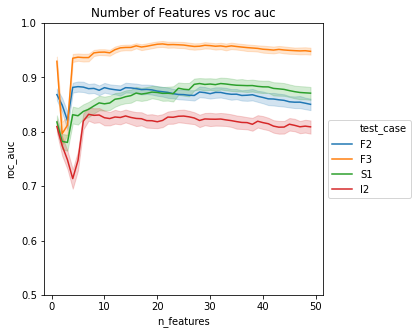

In [100]:
plt.figure(figsize=(5,5))
sns.lineplot(x='n_features',y='roc_auc',hue='test_case', data=summary_n_features)
plt.ylim([0.5,1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs roc auc')
plt.show()

In [101]:
combined = summary_n_features.groupby(['test_case','n_features']).mean()

best = combined.sort_values(by='f1', ascending=False).groupby('test_case').head(1)
best

,,precision,recall,f1,balanced_accuracy,roc_auc,num_feat,n_obs,roc_auc_2
test_case,n_features,,,,,,,,
S1,28,0.820613,0.838379,0.826767,0.804326,0.888824,28,350,0.888824
F3,21,0.878035,0.780296,0.822877,0.870872,0.961695,21,358,0.961695
F2,14,0.846504,0.801482,0.820944,0.807893,0.881211,14,358,0.881211
I2,9,0.780286,0.770973,0.773043,0.760441,0.830920,9,350,0.830920


In [102]:
best_dict = {}
for i, j in best.index.to_list():
    best_dict[i] = j
best_dict

{'S1': 28, 'F3': 21, 'F2': 14, 'I2': 9}

### Top k selected proteins for prediction
[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information. 

Each endpoint will yield different `top-k` proteins. An aggregation strategy in the simplest form is to combine the top-k. Maybe there is also some kind of rank-algorithm combining the top-k minimizing the overall rank?

In [103]:
protein_panels={}

for end_point, dichotomy in targets_dict.items():
    k=best_dict[end_point]
    feature_selected = FeatureSelector(k=k, protein_gene_data=key_ProteinID)
    protein_panels[end_point] = feature_selected.fit(data_proteomics, dichotomy, end_point)

    
proteins_selected_f2=protein_panels['F2']
proteins_selected_f3=protein_panels['F3']
proteins_selected_s1=protein_panels['S1']
proteins_selected_I2=protein_panels['I2']

In [104]:
proteins_selected_f2.T

Protein ID,P10643,P19320,Q16270,P35858,P02743,A0A0G2JMB2,O00391,Q08380,P01833,P00739,A0A0A0MRZ8,Q99650,Q9Y5Y7,Q15582
F2,C7,VCAM1,IGFBP7,IGFALS,APCS,IGHA2,QSOX1,LGALS3BP,PIGR,HPR,IGKV3D-11,OSMR,LYVE1,TGFBI


In [105]:
proteins_selected_f3.T

Protein ID,P10643,P19320,O00391,P02743,Q16270,Q08380,A0A286YEY1,P27169,Q9Y5Y7,P51884,...,P05546,A0A0G2JMB2,Q99650,P01834,P35858,P01619,K7ERI9,Q15485,Q15582,P0DOY2
F3,C7,VCAM1,QSOX1,APCS,IGFBP7,LGALS3BP,IGHA1,PON1,LYVE1,LUM,...,SERPIND1,IGHA2,OSMR,IGKC,IGFALS,IGKV3-20,APOC1,FCN2,TGFBI,IGLC2


In [106]:
proteins_selected_s1.T

Protein ID,P05062,Q08380,H7BY64,P06396,C9JPQ9,P19320,Q15582,P55103,P08519,Q92820,...,P43652,P04196,Q9Y5Y7,B0YIW2,P80748,A0A0U1RR20,P09172,P01009,P0C0L5,A0A182DWH7
S1,ALDOB,LGALS3BP,NoGene,GSN,FGG,VCAM1,TGFBI,INHBC,LPA,GGH,...,AFM,HRG,LYVE1,APOC3,IGLV3-21,PRG4,DBH,SERPINA1,C4B,SELENOP


In [107]:
proteins_selected_I2.T

Protein ID,Q08380,P10643,P01833,Q16270,O00391,P10909,P23142,P05362,P05546
I2,LGALS3BP,C7,PIGR,IGFBP7,QSOX1,CLU,FBLN1,ICAM1,SERPIND1


In [108]:
# don't label by gene to retain scoring information (to sort at least by endpoint for importance)
protein_panels_scores={}
for end_point, dichotomy in targets_dict.items():
    k=best_dict[end_point]
    feature_selected = FeatureSelector(k=k)
    protein_panels_scores[end_point] = feature_selected.fit(data_proteomics, dichotomy, end_point)

In [109]:
def get_feature_comp(protein_panel:dict, exclude=[], order=None):
    """Custom processor for dictonary holding multual information DataFrame per endpoint
        from above."""
    for i, (endpoint, _df) in enumerate(protein_panel.items()):
        if endpoint not in exclude:
            if i == 0:
                df_protein_panel = _df
            else:
                df_protein_panel = df_protein_panel.join(_df, how='outer')
    if order:
        df_protein_panel = df_protein_panel[order]
    mask = df_protein_panel.isna()   
    # df_protein_panel.where(mask, other=1).fillna(0).sort_values(by=list, ascending=False)
    return df_protein_panel.sort_values(by=list(df_protein_panel.columns), ascending=False).fillna('-')

df_protein_panel = get_feature_comp(protein_panel=protein_panels_scores, exclude=['F3'], order=['F2', 'I2', 'S1'])
df_protein_panel['Gene Name'] = key_ProteinID.loc[df_protein_panel.index]

In [110]:
pd.set_option('precision', 3)
display(df_protein_panel.head(10))

,F2,I2,S1,Gene Name
Protein ID,,,,
P10643,0.263,0.148,-,C7
P19320,0.201,-,0.085,VCAM1
Q16270,0.193,0.121,-,IGFBP7
P35858,0.191,-,0.0706,IGFALS
P02743,0.15,-,-,APCS
A0A0G2JMB2,0.141,-,-,IGHA2
O00391,0.138,0.107,-,QSOX1
Q08380,0.131,0.177,0.092,LGALS3BP
P01833,0.125,0.122,-,PIGR


In [111]:
len(df_protein_panel)

41

For the four endpoints a total of 41 prot

Only one protein, 

### Executor 

corresponds to main function in a script. Allows changes over all endpoints simultaneously. 

In [112]:
from src.cross_validation import MainExecutorCV
cv_executor = MainExecutorCV(proteomics_data=data_proteomics, clinical_data=data_cli, demographics=demographics, clf_sklearn=clf_sklearn, cutoffs_clinic=cutoffs_clinic)

1. Models based on clinical marker thresholds (Clinical Reference Models) - defined by `cutoffs_clinic`
2. Additional Models based on clinical markers (having no standard cutoffs defined or if data dependent cutoff is wanted) - defined by list `additional_markers`
    - As this depends on the endpoint, it is 
3. Proteomics Models based on protein intensities

Performance depends on the number of available features (varies!) 

In [113]:
ADD_DEMOGRAPHICS = False
INTERACTION_DEGREE = 1

### Fibrosis

#### F2

In [114]:
kleiner_ge_2.value_counts(dropna=False)

1    200
0    160
Name: kleiner, dtype: int64

In [115]:
cutoffs_f2 = cutoffs_clinic['F2'].dropna().to_dict()
cutoffs_f2

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

In [116]:
y = kleiner_ge_2.astype(int)
y.describe()

count    360.000
mean       0.556
std        0.498
min        0.000
25%        0.000
50%        1.000
75%        1.000
max        1.000
Name: kleiner, dtype: float64

In [117]:
f2_results, f2_auc_scores, f2_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_2,
                                                       endpoint='F2',
                                                       additional_markers=['forns', 'p3np'],
                                                       proteins_selected=proteins_selected_f2,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices,
                                                       verbose=False)
result_table_f2 = _get_cv_means(f2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f2

variable                 precision        recall            f1         \
statistics                    mean    std   mean    std   mean    std   
F2_prot_Logistic             0.847  0.060  0.801  0.058  0.821  0.040   
F2_marker_te                 0.762  0.059  0.822  0.045  0.789  0.040   
F2_marker_elf_Logistic       0.762  0.076  0.826  0.065  0.788  0.042   
F2_marker_te_Logistic        0.858  0.071  0.732  0.066  0.786  0.045   
F2_marker_swe                0.795  0.047  0.778  0.047  0.785  0.036   
F2_marker_ft_Logistic        0.847  0.075  0.737  0.086  0.784  0.059   
F2_marker_swe_Logistic       0.857  0.042  0.711  0.053  0.776  0.036   
F2_marker_forns_Logistic     0.722  0.067  0.774  0.063  0.744  0.046   
F2_marker_fib4               0.744  0.060  0.744  0.056  0.742  0.049   
F2_marker_p3np_Logistic      0.820  0.078  0.669  0.092  0.731  0.065   
F2_marker_elf                0.573  0.053  0.995  0.011  0.725  0.044   
F2_marker_apri_Logistic      0.797  0.092  0.666  0.084  0.719  0.060   
F2_marker_fib4_Logistic      0.786  0.073  0.669  0.075  0.718  0.051   
F2_marker_apri               0.836  0.074  0.566  0.077  0.671  0.066   
F2_marker_ft                 0.909  0.078  0.492  0.064  0.636  0.060   

variable                 balanced_accuracy        roc_auc        num_feat  \
statistics                            mean    std    mean    std     mean   
F2_prot_Logistic                     0.808  0.044   0.881  0.032     14.0   
F2_marker_te                         0.756  0.042   0.756  0.042      1.0   
F2_marker_elf_Logistic               0.751  0.047   0.852  0.038      1.0   
F2_marker_te_Logistic                0.791  0.047   0.874  0.030      1.0   
F2_marker_swe                        0.769  0.038   0.769  0.038      1.0   
F2_marker_ft_Logistic                0.793  0.053   0.864  0.042      1.0   
F2_marker_swe_Logistic               0.784  0.035   0.880  0.026      1.0   
F2_marker_forns_Logistic             0.701  0.051   0.809  0.045      1.0   
F2_marker_fib4                       0.711  0.045   0.711  0.045      1.0   
F2_marker_p3np_Logistic              0.750  0.051   0.805  0.045      1.0   
F2_marker_elf                        0.533  0.026   0.533  0.026      1.0   
F2_marker_apri_Logistic              0.726  0.053   0.766  0.050      1.0   
F2_marker_fib4_Logistic              0.720  0.042   0.786  0.043      1.0   
F2_marker_apri                       0.713  0.044   0.713  0.044      1.0   
F2_marker_ft                         0.719  0.041   0.719  0.041      1.0   

variable                       n_obs      roc_auc_2         
statistics                std   mean  std      mean    std  
F2_prot_Logistic          0.0  358.0  0.0     0.881  0.032  
F2_marker_te              0.0  341.0  0.0     0.756  0.042  
F2_marker_elf_Logistic    0.0  349.0  0.0     0.852  0.038  
F2_marker_te_Logistic     0.0  341.0  0.0     0.874  0.030  
F2_marker_swe             0.0  331.0  0.0     0.769  0.038  
F2_marker_ft_Logistic     0.0  268.0  0.0     0.864  0.042  
F2_marker_swe_Logistic    0.0  331.0  0.0     0.880  0.026  
F2_marker_forns_Logistic  0.0  356.0  0.0     0.809  0.045  
F2_marker_fib4            0.0  352.0  0.0     0.711  0.045  
F2_marker_p3np_Logistic   0.0  319.0  0.0     0.805  0.045  
F2_marker_elf             0.0  349.0  0.0     0.533  0.026  
F2_marker_apri_Logistic   0.0  353.0  0.0     0.766  0.050  
F2_marker_fib4_Logistic   0.0  352.0  0.0     0.786  0.043  
F2_marker_apri            0.0  353.0  0.0     0.713  0.044  
F2_marker_ft              0.0  268.0  0.0     0.719  0.041

In [118]:
assert result_table_f2.loc['F2_prot_Logistic', ('roc_auc', 'mean')] - 0.8812105411992736 < 0.00001, "Final results not reproduced."

#### F3

In [119]:
kleiner_ge_3.value_counts(dropna=False)

0    266
1     94
Name: kleiner, dtype: int64

In [120]:
cutoffs_f3 = cutoffs_clinic['F3'].dropna().to_dict()
cutoffs_f3

{'te': 15.0,
 'swe': 16.4,
 'elf': 10.5,
 'ft': 0.58,
 'fib4': 3.25,
 'apri': 1.0,
 'forns': 6.8}

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

In [121]:
f3_results, f3_auc_scores, f3_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_3, endpoint='F3', 
                                                       additional_markers=['p3np'], 
                                                       proteins_selected=proteins_selected_f3,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices)
result_table_f3 = _get_cv_means(f3_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f3

variable                 precision        recall            f1         \
statistics                    mean    std   mean    std   mean    std   
F3_marker_swe                0.854  0.070  0.831  0.078  0.839  0.055   
F3_marker_te                 0.793  0.070  0.893  0.069  0.837  0.053   
F3_prot_Logistic             0.878  0.068  0.780  0.090  0.823  0.066   
F3_marker_swe_Logistic       0.869  0.072  0.689  0.105  0.762  0.071   
F3_marker_elf                0.700  0.081  0.756  0.093  0.724  0.068   
F3_marker_te_Logistic        0.844  0.102  0.628  0.122  0.711  0.092   
F3_marker_forns              0.641  0.091  0.701  0.090  0.667  0.078   
F3_marker_ft                 0.649  0.124  0.640  0.120  0.637  0.102   
F3_marker_ft_Logistic        0.746  0.124  0.551  0.132  0.624  0.108   
F3_marker_fib4               0.690  0.101  0.578  0.113  0.623  0.092   
F3_marker_forns_Logistic     0.752  0.105  0.476  0.104  0.576  0.094   
F3_marker_p3np_Logistic      0.758  0.151  0.428  0.113  0.536  0.107   
F3_marker_elf_Logistic       0.928  0.093  0.373  0.124  0.517  0.130   
F3_marker_apri               0.518  0.111  0.370  0.105  0.425  0.097   
F3_marker_fib4_Logistic      0.680  0.189  0.233  0.119  0.332  0.141   
F3_marker_apri_Logistic      0.452  0.372  0.063  0.064  0.105  0.097   

variable                 balanced_accuracy        roc_auc        num_feat  \
statistics                            mean    std    mean    std     mean   
F3_marker_swe                        0.891  0.040   0.891  0.040      1.0   
F3_marker_te                         0.907  0.035   0.907  0.035      1.0   
F3_prot_Logistic                     0.871  0.047   0.962  0.018     21.0   
F3_marker_swe_Logistic               0.826  0.049   0.954  0.022      1.0   
F3_marker_elf                        0.822  0.048   0.822  0.048      1.0   
F3_marker_te_Logistic                0.794  0.060   0.955  0.024      1.0   
F3_marker_forns                      0.780  0.052   0.780  0.052      1.0   
F3_marker_ft                         0.763  0.066   0.763  0.066      1.0   
F3_marker_ft_Logistic                0.744  0.068   0.904  0.042      1.0   
F3_marker_fib4                       0.743  0.060   0.743  0.060      1.0   
F3_marker_forns_Logistic             0.710  0.052   0.843  0.047      1.0   
F3_marker_p3np_Logistic              0.692  0.058   0.842  0.062      1.0   
F3_marker_elf_Logistic               0.681  0.060   0.912  0.029      1.0   
F3_marker_apri                       0.623  0.055   0.623  0.055      1.0   
F3_marker_fib4_Logistic              0.597  0.054   0.835  0.049      1.0   
F3_marker_apri_Logistic              0.520  0.030   0.785  0.056      1.0   

variable                       n_obs      roc_auc_2         
statistics                std   mean  std      mean    std  
F3_marker_swe             0.0  331.0  0.0     0.891  0.040  
F3_marker_te              0.0  341.0  0.0     0.907  0.035  
F3_prot_Logistic          0.0  358.0  0.0     0.962  0.018  
F3_marker_swe_Logistic    0.0  331.0  0.0     0.954  0.022  
F3_marker_elf             0.0  349.0  0.0     0.822  0.048  
F3_marker_te_Logistic     0.0  341.0  0.0     0.955  0.024  
F3_marker_forns           0.0  356.0  0.0     0.780  0.052  
F3_marker_ft              0.0  268.0  0.0     0.763  0.066  
F3_marker_ft_Logistic     0.0  268.0  0.0     0.904  0.042  
F3_marker_fib4            0.0  352.0  0.0     0.743  0.060  
F3_marker_forns_Logistic  0.0  356.0  0.0     0.843  0.047  
F3_marker_p3np_Logistic   0.0  319.0  0.0     0.842  0.062  
F3_marker_elf_Logistic    0.0  349.0  0.0     0.912  0.029  
F3_marker_apri            0.0  353.0  0.0     0.623  0.055  
F3_marker_fib4_Logistic   0.0  352.0  0.0     0.835  0.049  
F3_marker_apri_Logistic   0.0  353.0  0.0     0.785  0.056

Using one of the models (or the ensemble), one could expect some predictions of fibrosis patients in the untested healthy patient (hp) cohort.

### Inflamation

In [122]:
inflamation_ge_2.value_counts(dropna=False)

1    189
0    163
Name: nas_inflam, dtype: int64

In [123]:
cutoffs_i2 = cutoffs_clinic['I2'].dropna().to_dict()
cutoffs_i2

{'aar': 2.0}

##### Reference Model: Based on clinical markerthresholds

In [124]:
i2_results, i2_auc_scores, i2_prc_scores = cv_executor.run_evaluation(y=inflamation_ge_2, endpoint='I2', 
                                                       additional_markers=['m30', 'm65'], 
                                                       proteins_selected=proteins_selected_I2,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices)
result_table_i2 = _get_cv_means(i2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_i2

variable               precision        recall            f1         \
statistics                  mean    std   mean    std   mean    std   
I2_prot_Logistic           0.780  0.062  0.771  0.082  0.773  0.059   
I2_marker_m30_Logistic     0.751  0.079  0.599  0.090  0.661  0.065   
I2_marker_m65_Logistic     0.712  0.093  0.565  0.101  0.622  0.072   
I2_marker_aar_Logistic     0.582  0.075  0.639  0.108  0.601  0.062   
I2_marker_aar              0.812  0.102  0.212  0.066  0.331  0.085   

variable               balanced_accuracy        roc_auc        num_feat       \
statistics                          mean    std    mean    std     mean  std   
I2_prot_Logistic                   0.760  0.053   0.831  0.045      9.0  0.0   
I2_marker_m30_Logistic             0.693  0.049   0.767  0.052      1.0  0.0   
I2_marker_m65_Logistic             0.662  0.058   0.713  0.063      1.0  0.0   
I2_marker_aar_Logistic             0.552  0.053   0.595  0.065      1.0  0.0   
I2_marker_aar                      0.578  0.036   0.578  0.036      1.0  0.0   

variable                n_obs      roc_auc_2         
statistics               mean  std      mean    std  
I2_prot_Logistic        350.0  0.0     0.831  0.045  
I2_marker_m30_Logistic  266.0  0.0     0.767  0.052  
I2_marker_m65_Logistic  264.0  0.0     0.713  0.063  
I2_marker_aar_Logistic  344.0  0.0     0.595  0.065  
I2_marker_aar           344.0  0.0     0.578  0.036

### Steatosis

In [125]:
steatosis_ge_1.value_counts(dropna=False)

1    196
0    156
Name: nas_steatosis_ordinal, dtype: int64

In [126]:
cutoffs_s1 = cutoffs_clinic['S1'].dropna().to_dict()
cutoffs_s1

{'cap': 290.0}

In [127]:
y = steatosis_ge_1.astype(int)
y.describe()

count    352.000
mean       0.557
std        0.497
min        0.000
25%        0.000
50%        1.000
75%        1.000
max        1.000
Name: nas_steatosis_ordinal, dtype: float64

In [128]:
s1_results, s1_auc_scores, s1_prc_scores = cv_executor.run_evaluation(y=steatosis_ge_1, endpoint='S1', 
                                                       additional_markers=[], 
                                                       proteins_selected=proteins_selected_s1,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices)
result_table_s1 = _get_cv_means(s1_results).sort_values(('f1', 'mean'), ascending = False)
result_table_s1

variable               precision        recall            f1         \
statistics                  mean    std   mean    std   mean    std   
S1_marker_cap_Logistic     0.752  0.080  0.931  0.047  0.829  0.052   
S1_prot_Logistic           0.821  0.074  0.838  0.068  0.827  0.053   
S1_marker_cap              0.888  0.074  0.634  0.085  0.736  0.068   

variable               balanced_accuracy        roc_auc        num_feat       \
statistics                          mean    std    mean    std     mean  std   
S1_marker_cap_Logistic             0.689  0.069   0.827  0.058      1.0  0.0   
S1_prot_Logistic                   0.804  0.053   0.889  0.039     28.0  0.0   
S1_marker_cap                      0.749  0.056   0.749  0.056      1.0  0.0   

variable                n_obs      roc_auc_2         
statistics               mean  std      mean    std  
S1_marker_cap_Logistic  199.0  0.0     0.827  0.058  
S1_prot_Logistic        350.0  0.0     0.889  0.039  
S1_marker_cap           199.0  0.0     0.749  0.056

### Write results to Excel

In [129]:
FILE_RESULTS = 'results.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    result_table_f2.to_excel(writer, sheet_name='F2_featureOptim')
    result_table_f3.to_excel(writer, sheet_name='F3_featureOptim')
    result_table_i2.to_excel(writer, sheet_name='I2_featureOptim')
    result_table_s1.to_excel(writer, sheet_name='S1_featureOptim')

## Plot Results of Cross validation for three endpoints (F2, I2, S1)

- create [enumeration of subplots](https://stackoverflow.com/a/25544329/9684872) starting at a)

In [130]:
map_names = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'naming_scheme.csv'), index_col='name_in_clinical_data')
map_names = map_names['name_in_plot'].to_dict()
map_names

{'te': 'TE',
 'swe': 'SWE',
 'forns': 'Forns',
 'apri': 'APRI',
 'aar': 'AAR',
 'fib4': 'FIB-4',
 'elf': 'ELF',
 'p3np': 'P3NP',
 'ft': 'FibroTest',
 'm30': 'M30',
 'm65': 'M65',
 'cap': 'CAP'}

Custom function to transform index names

In [131]:
display(result_table_s1)

def _process_names(index, map_names=map_names):
    """Helper function for custom labeling of models.
    This function is specific to any dataset and has to be rewritten.
    
    Parameters
    ----------
    index: pandas.Index
        Index to transform. Index names are composite word
        combined with '_' here.
    map_names: dict
        Mapping of names to apply to words.
    """
    names = list(index)
    names = [x.split('_') for x in names]
    endpoint = names[0][0]
    
    def _process_index_names(_l:list):
        REMOVE = 'marker'
        if REMOVE in _l:
            _l.remove(REMOVE)
        _l = [word if not word in map_names else map_names[word] for word in _l]
        CHANGE = {'Logistic': 'Model',
                  'prot': 'Proteomics'}
        _l = [word if not word in CHANGE else CHANGE[word] for word in _l]
        if CHANGE['Logistic'] not in _l:
            _l.append('Test')
        return _l
    
    for _l in names: assert endpoint == _l[0] , f"Mixed endpoints: {endpoint} and {_l[0]}"
    names = [" ".join(_process_index_names(_l[1:])) for _l in names]
    return names

_process_names(result_table_s1.index)

variable               precision        recall            f1         \
statistics                  mean    std   mean    std   mean    std   
S1_marker_cap_Logistic     0.752  0.080  0.931  0.047  0.829  0.052   
S1_prot_Logistic           0.821  0.074  0.838  0.068  0.827  0.053   
S1_marker_cap              0.888  0.074  0.634  0.085  0.736  0.068   

variable               balanced_accuracy        roc_auc        num_feat       \
statistics                          mean    std    mean    std     mean  std   
S1_marker_cap_Logistic             0.689  0.069   0.827  0.058      1.0  0.0   
S1_prot_Logistic                   0.804  0.053   0.889  0.039     28.0  0.0   
S1_marker_cap                      0.749  0.056   0.749  0.056      1.0  0.0   

variable                n_obs      roc_auc_2         
statistics               mean  std      mean    std  
S1_marker_cap_Logistic  199.0  0.0     0.827  0.058  
S1_prot_Logistic        350.0  0.0     0.889  0.039  
S1_marker_cap           199.0  0.0     0.749  0.056

['CAP Model', 'Proteomics Model', 'CAP Test']

### Performance Plots based on results DataFrame for a endpoint

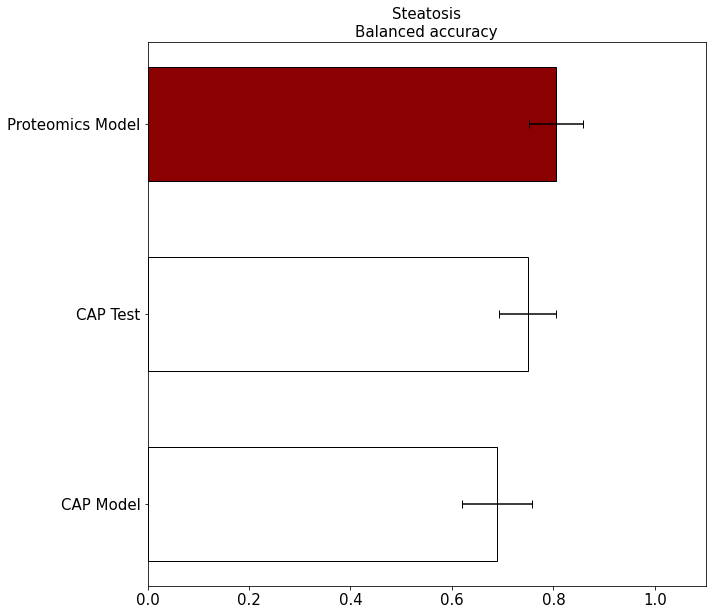

In [132]:
from src.plots import plot_performance
fig, ax = plt.subplots(figsize=(10,10))
plot_performance(ax, result_table_s1, 'balanced_accuracy', 'Steatosis', _process_index=_process_names)

### AUC-ROC Curves based on CV result for an endpoint

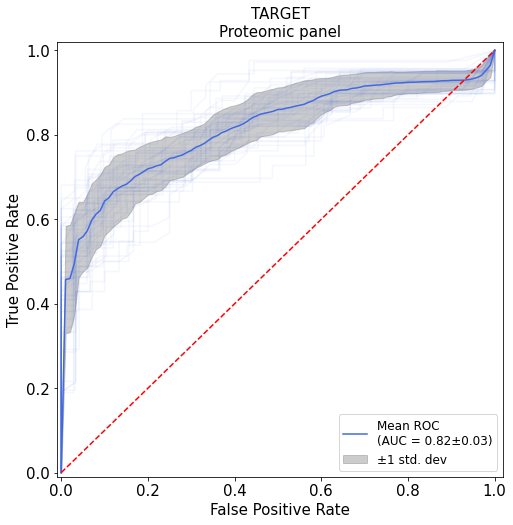

In [133]:
from src.plots import plot_roc_curve

fig, ax = plt.subplots(figsize=(8, 8))      
        
plot_roc_curve(ax, roc_curve_results['F2_Logistic'], 'TARGET')

### Precision Recall Curve

95% CI:(0.8716844242532462, 0.8883155757467538)


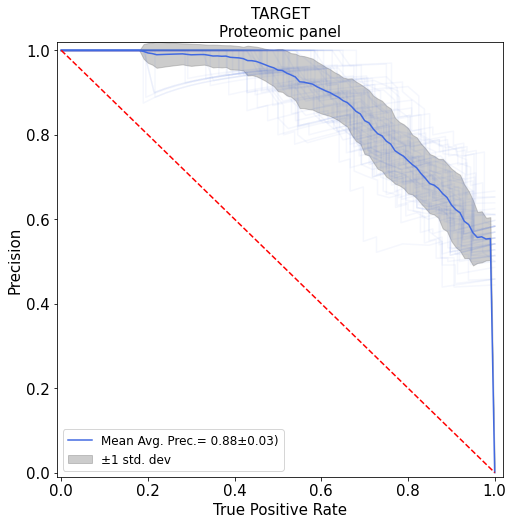

In [134]:
from src.plots import plot_prc_curve
fig, ax = plt.subplots(figsize=(8, 8))
plot_prc_curve(ax, precision_recall_results['F2_Logistic'], 'TARGET')

### Build final figure for publication

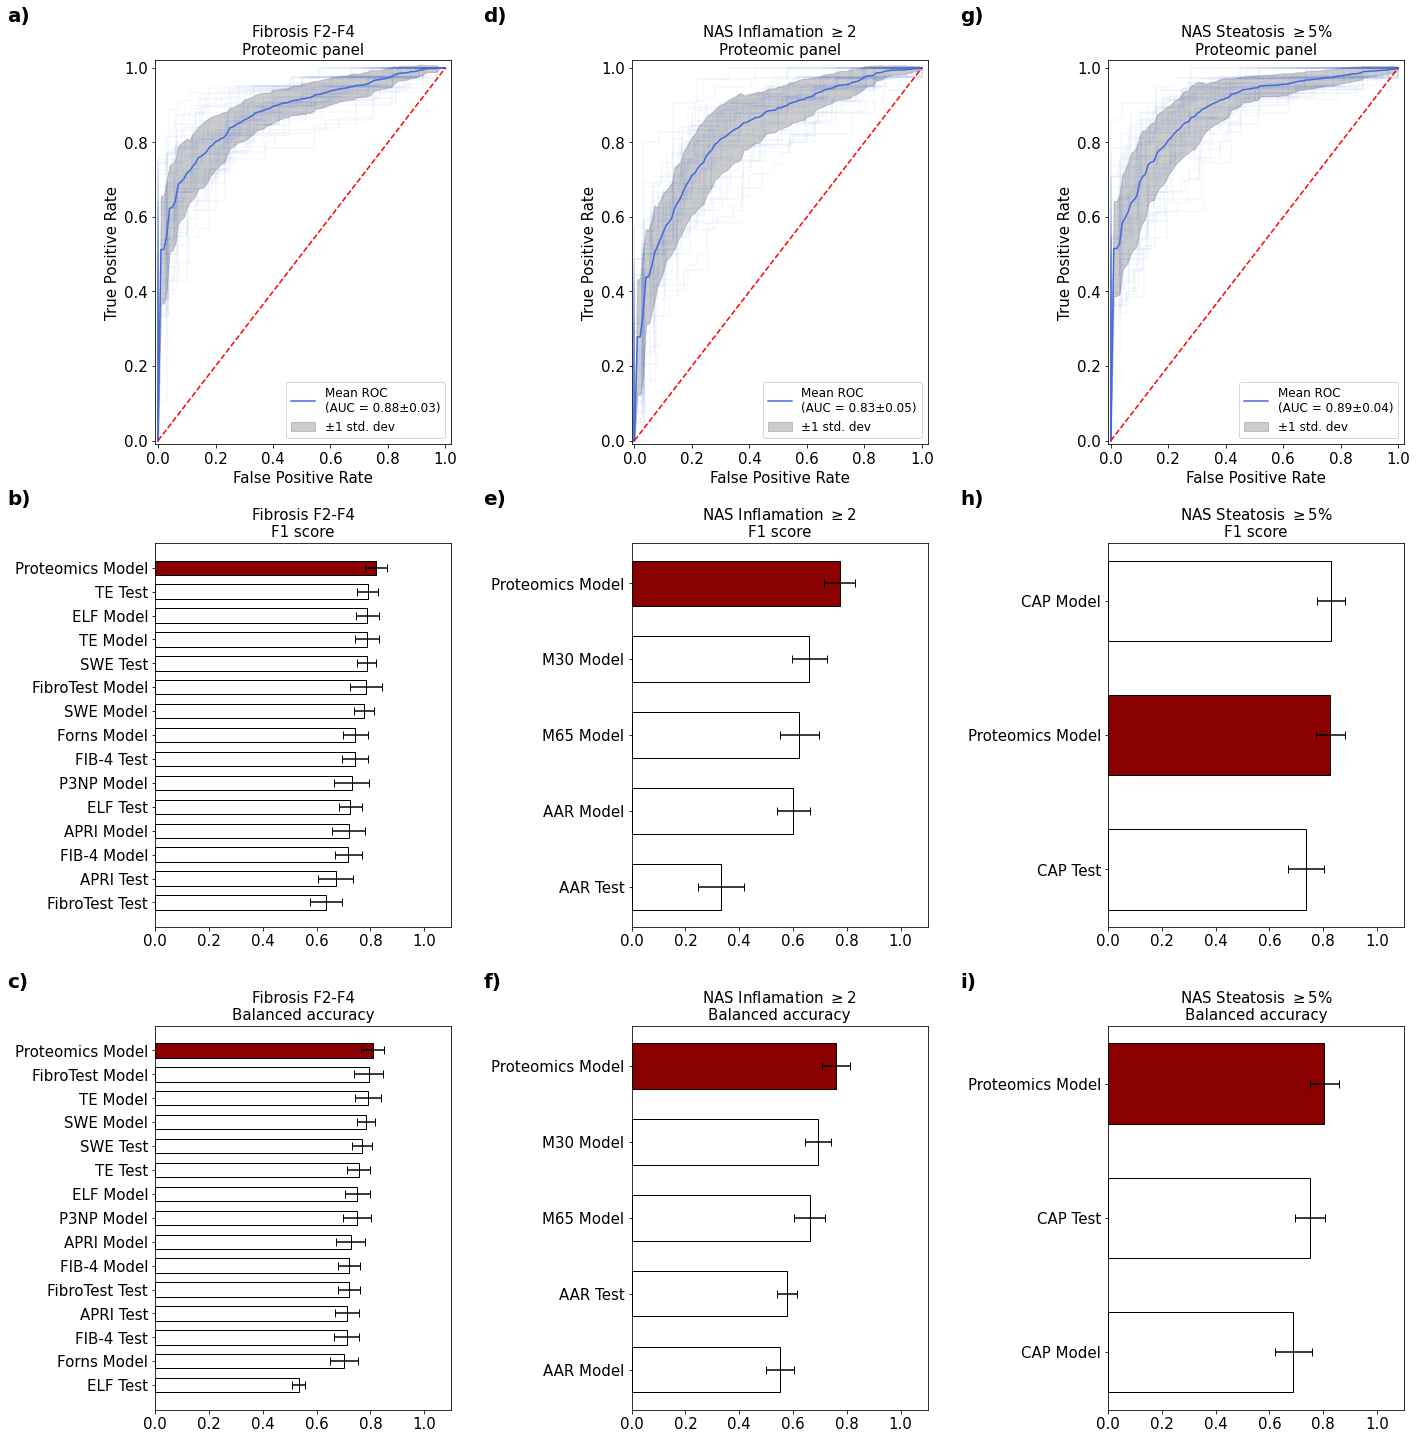

In [135]:
import string
fig, axs = plt.subplots(3,3,figsize=(20,20))

n=0
result_tuples = [
 (result_table_f2, f2_auc_scores, 'Fibrosis F2-F4', 'F2_prot_Logistic'), 
 (result_table_i2, i2_auc_scores, 'NAS Inflamation $\geq 2$', 'I2_prot_Logistic'), 
 (result_table_s1, s1_auc_scores, 'NAS Steatosis $\geq 5$%', 'S1_prot_Logistic')
]

for col, (result_table, result_auc_scores, endpoint_title, auc_model_name) in enumerate(result_tuples):
    
    ax = axs[0,col]
    plot_roc_curve(ax, result_auc_scores[auc_model_name], endpoint_title)
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[1,col]
    plot_performance(ax, result=result_table, metric='f1', title=endpoint_title,  _process_index=_process_names)   
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[2,col]
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    plot_performance(ax, result=result_table, metric='balanced_accuracy', title=endpoint_title, _process_index=_process_names)   

    n+=1

fig.tight_layout()
fig.savefig('figures/Figure_6.pdf', dpi=120, pad_inches=0.1, bbox_inches='tight')

## Final model

1. Either pick one of the models run during CV
2. Aggregate metrics over all CV runs for obs in test set (~ mean of CV results)
3. Perform new train/test split.


Steps to implement

1.  Select model with median aucroc performance
2.  Report summary statistics (mean, median, min, max)
3.  [DeLong](https://github.com/llniu/roc_comparison)
4.  Target Scores for three endpoints of final prediction model


### Check Cross Validation results (for comparison)

#### Look at descriptive statistics of CV

- depending on the split the performance varies. The `min`, `max`, `mean`, etc. are given per model, therefore it's not the given split. Selecting a split of the data which supports one's conclusion can be misleading.

In [136]:
results = {
 "F2":f2_results,
 "F3":f3_results,
 "I2":i2_results,
 "S1":s1_results
}

In [137]:
results_combinded = {}
for _results in results.values(): results_combinded.update(_results)
results_combinded.keys()

dict_keys(['F2_marker_te', 'F2_marker_swe', 'F2_marker_elf', 'F2_marker_ft', 'F2_marker_fib4', 'F2_marker_apri', 'F2_marker_forns_Logistic', 'F2_marker_p3np_Logistic', 'F2_marker_te_Logistic', 'F2_marker_swe_Logistic', 'F2_marker_elf_Logistic', 'F2_marker_ft_Logistic', 'F2_marker_fib4_Logistic', 'F2_marker_apri_Logistic', 'F2_prot_Logistic', 'F3_marker_te', 'F3_marker_swe', 'F3_marker_elf', 'F3_marker_ft', 'F3_marker_fib4', 'F3_marker_apri', 'F3_marker_forns', 'F3_marker_p3np_Logistic', 'F3_marker_te_Logistic', 'F3_marker_swe_Logistic', 'F3_marker_elf_Logistic', 'F3_marker_ft_Logistic', 'F3_marker_fib4_Logistic', 'F3_marker_apri_Logistic', 'F3_marker_forns_Logistic', 'F3_prot_Logistic', 'I2_marker_aar', 'I2_marker_m30_Logistic', 'I2_marker_m65_Logistic', 'I2_marker_aar_Logistic', 'I2_prot_Logistic', 'S1_marker_cap', 'S1_marker_cap_Logistic', 'S1_prot_Logistic'])

In [138]:
def show_summary(results_dict, metric='f1', sort=True, save=False):
    _df = pd.DataFrame(results_dict).loc[metric].apply(pd.Series).T.describe()
    _df.index.name = metric
    if sort:
        _df = _df.sort_values(by='mean', axis=1, ascending=False)
    if save:
        fname = "cv_stats_{}{}.xlsx".format(metric, '_sorted' if save else '')
        fname = os.path.join(TABLEFOLDER, fname)
        _df.to_excel(fname)
        print(f'Saved Table to: {fname}')
    return _df

In [139]:
out= widgets.interact(show_summary, metric=scoring, results_dict=widgets.fixed(results_combinded))

interactive(children=(Dropdown(description='metric', index=2, options=('precision', 'recall', 'f1', 'balanced_…

#### Select a model from the CV run (and compare it to others)

In [140]:
l_models = list(results_combinded.keys())
ref_model=l_models[14] # 'F2_prot_Logistic'
metric=scoring[2]      # 'f1'

In [141]:
def compare_models(ref_model:str, metric:str, data:dict, fct=np.median):
    """Select comparison. The first column is the referenc model.
    If the metric of the summary statistic is present several times in the model, this value is returned."""
    ref_model_metric_values = np.array(data[ref_model][metric])
    ref_model_metric = fct(ref_model_metric_values)
    ref_model_metric_idx = (np.abs(ref_model_metric_values - ref_model_metric)).argmin() #ToDo: return both closest values for median.
    ref_model_metric = ref_model_metric_values[ref_model_metric_idx]
    matches = [index for index, item in enumerate(ref_model_metric_values) if item == ref_model_metric]

    _results = pd.DataFrame(ref_model_metric_values[matches], columns=[ref_model], index=matches)
    _results.index.name = 'run'
    
    _selected_results = {}
    
    
    for _model, _result in data.items():
        if not _model == ref_model:
            _selected_results[_model] = [_result[metric][item] for item in matches]
    #sorting of values over last result
    _other = pd.DataFrame(_selected_results, index=matches)
    _other = _other.sort_values(by=matches[-1], axis=1, ascending=False)
    return _results.join(_other)

# compare_models(ref_model=ref_model, metric='precision', data=f2_results, fct=lambda x: np.quantile(x, q=0.6))

In [142]:
protein_model_name = {endpoint: f'{endpoint}_prot_Logistic'for endpoint in end_points}
metrics_np_fct = {'median': np.median, '3rd quintile': lambda x: np.quantile(x, q=0.6), 'mean': np.mean, 'max': np.max, 'min': np.min }

#needs global dictionaries: protein_model_name, metrics_np_fct, results
def _caller_comp(metric, endpoint, selector):
    """Helper function to use with ipykernel"""
    df = compare_models(ref_model=protein_model_name[endpoint], metric=metric, data=results[endpoint], fct=metrics_np_fct[selector])
    df.columns.name = selector
    return df
# _caller_comp('f1', 'I2', 'median')

In [143]:
out2= widgets.interact(_caller_comp, metric=scoring, endpoint=results.keys(), selector=metrics_np_fct.keys())

interactive(children=(Dropdown(description='metric', options=('precision', 'recall', 'f1', 'balanced_accuracy'…

### Train a new final model

Adjust `run_cv_binary`

In [144]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data_cli_missing_table, stratifier, test_size=0.2, random_state=42)

In [145]:
train_test_split_final = [(X_train.index, X_test.index)] # list of (train, test) indices. Does not throw a nice error message otherwise.

Adapted the executor to take as argument a different function.

In [146]:
arguments = {}
arguments['F2'] = {'target': kleiner_ge_2, 'proteins': proteins_selected_f2, 'add_markers': ['forns', 'p3np']} 
arguments['F3'] = {'target': kleiner_ge_3, 'proteins': proteins_selected_f3, 'add_markers': ['p3np']}
arguments['I2'] = {'target': inflamation_ge_2, 'proteins': proteins_selected_I2, 'add_markers': ['m30', 'm65']}
arguments['S1'] = {'target': steatosis_ge_1, 'proteins': proteins_selected_s1, 'add_markers': []}

In [147]:
ADD_DEMOGRAPHICS = False
FOLDER_FINAL_SCORES = 'final_model_scores'

import importlib; importlib.reload(src.cross_validation)
from src.cross_validation import run_cv_binary
prediction_folder = os.path.join(TABLEFOLDER, FOLDER_FINAL_SCORES)


from functools import partial
run_cv_binary_final = partial(run_cv_binary, save_predictions=True, folder=prediction_folder)


results_final = {}

for endpoint, args in arguments.items():
    results_final[endpoint] = cv_executor.run_evaluation(y=args['target'],
                                                       endpoint=endpoint,
                                                       additional_markers=args['add_markers'],
                                                       proteins_selected=args['proteins'],
                                                       evaluator_fct=run_cv_binary_final,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=train_test_split_final,
                                                       verbose=False)

In [148]:
def display_result(endpoint):
    return pd.DataFrame(results_final[endpoint][0]).applymap(lambda x: x[0]).T.sort_values('f1', ascending=False)


# pd.DataFrame(results_final['F2'][0]).T.sort_values('f1', ascending=False)
out3= widgets.interact(display_result, endpoint=results_final.keys())

interactive(children=(Dropdown(description='endpoint', options=('F2', 'F3', 'I2', 'S1'), value='F2'), Output()…

#### DeLong-Test on final model

First a check of the [implementation](https://github.com/yandexdataschool/roc_comparison) by using a toy example derived in detail in Rachel Draelos' [blog-post](https://glassboxmedicine.com/2020/02/04/comparing-aucs-of-machine-learning-models-with-delongs-test/), where she also references the original DeLong paper from 1988 and a paper on a fast implementation described by Xu Sun and Weichao Xu from 2014.

In [149]:
import numpy as np
from roc_comparison import compare_auc_delong_xu

ground_trouth = np.array([0,0,1,1,1])
pred_model_a  = np.array([0.1,0.2,0.6,0.7,0.8])
pred_model_b  = np.array([0.3,0.6,0.2,0.7,0.9])

log10_pvalue = compare_auc_delong_xu.delong_roc_test(ground_truth=ground_trouth,
                                      predictions_one=pred_model_a,
                                      predictions_two=pred_model_b
                                 )
assert np.round(10**log10_pvalue[0][0], 4) ==  0.3173 

The implementation currently returns an array of an array with a single float. This could be change to an normal array or a plain floating point number:

In [150]:
log10_pvalue[0][0], log10_pvalue[0] # one of the two

(-0.498515545827989, array([-0.49851555]))

Get list of dumped results from models.

In [151]:
folder_final_scores = os.path.join(TABLEFOLDER, FOLDER_FINAL_SCORES)
l_scores = [_csv for _csv in os.listdir(folder_final_scores) if 'Logistic.csv' in _csv]
l_scores

['F2_marker_apri_Logistic.csv',
 'F2_marker_elf_Logistic.csv',
 'F2_marker_fib4_Logistic.csv',
 'F2_marker_forns_Logistic.csv',
 'F2_marker_ft_Logistic.csv',
 'F2_marker_p3np_Logistic.csv',
 'F2_marker_swe_Logistic.csv',
 'F2_marker_te_Logistic.csv',
 'F2_prot_Logistic.csv',
 'F3_marker_apri_Logistic.csv',
 'F3_marker_elf_Logistic.csv',
 'F3_marker_fib4_Logistic.csv',
 'F3_marker_forns_Logistic.csv',
 'F3_marker_ft_Logistic.csv',
 'F3_marker_p3np_Logistic.csv',
 'F3_marker_swe_Logistic.csv',
 'F3_marker_te_Logistic.csv',
 'F3_prot_Logistic.csv',
 'I2_marker_aar_Logistic.csv',
 'I2_marker_m30_Logistic.csv',
 'I2_marker_m65_Logistic.csv',
 'I2_prot_Logistic.csv',
 'S1_marker_cap_Logistic.csv',
 'S1_prot_Logistic.csv']

Calculate the p-value based on the common subset of samples between models:

In [152]:
# #view defintion of imported function
#calc_p_value_delong_xu??

Compare all models between all endpoints and highlight the results

In [153]:
from src.delong import calc_p_value_delong_xu

model_1 = l_scores[0]
model_2 = l_scores[8]

print(
f"Delong-Test p-value between scores of model {model_1.split('.',1)[0]} and {model_2.split('.')[0]}: "
f"{calc_p_value_delong_xu(model_1=model_1, model_2=model_2, folder_dumps=folder_final_scores, verbose=True):.4f}")

Delong-Test p-value between scores of model F2_marker_apri_Logistic and F2_prot_Logistic: 0.0079


In [154]:
auc_comp_dict = {}

def highlight_significant(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for floats smaller
    equal to 0.05
    """
    color = 'red' if val <= 0.05 else 'black'
    return 'color: %s' % color

for endpoint in end_points:
    # models = [x for x in l_scores if endpoint in x]
    # model_names = [" ".join(x.split('.csv')[0].split('_')) for x in models]
    model_names = pd.DataFrame(results_final[endpoint][0]).applymap(lambda x: x[0]).T.sort_values('f1', ascending=False).index.to_list()
    model_names = [model for model in model_names if 'Logistic' in model]
    models = [f'{name}.csv' for name in model_names]
    _df = pd.DataFrame(0, index=models, columns=models)
    
    for i, model_1 in enumerate(models):
        for model_2 in models[i:]:
            if model_1 == model_2:
                _df.loc[model_1, model_2] = 1.0
            else:
                _auc_p_value = calc_p_value_delong_xu(model_1, model_2, folder_dumps=folder_final_scores)
                _df.loc[model_1, model_2] = _auc_p_value
                _df.loc[model_2, model_1] = _auc_p_value
    model_names = [" ".join(x.split('.csv')[0].split('_')) for x in model_names]
    _df.columns = model_names
    _df.index   = model_names
    _df =  _df.style.applymap(highlight_significant)
    display(_df)
    auc_comp_dict[endpoint] = _df

,F2 marker swe Logistic,F2 prot Logistic,F2 marker elf Logistic,F2 marker te Logistic,F2 marker apri Logistic,F2 marker fib4 Logistic,F2 marker forns Logistic,F2 marker ft Logistic,F2 marker p3np Logistic
F2 marker swe Logistic,1.000,0.553,0.876,0.433,0.084,0.031,0.067,0.105,0.160
F2 prot Logistic,0.553,1.000,0.884,0.392,0.008,0.005,0.013,0.319,0.344
F2 marker elf Logistic,0.876,0.884,1.000,0.454,0.038,0.006,0.054,0.173,0.144
F2 marker te Logistic,0.433,0.392,0.454,1.000,0.058,0.041,0.154,0.120,0.642
F2 marker apri Logistic,0.084,0.008,0.038,0.058,1.000,0.638,0.613,0.501,0.338
F2 marker fib4 Logistic,0.031,0.005,0.006,0.041,0.638,1.000,0.303,0.527,0.252
F2 marker forns Logistic,0.067,0.013,0.054,0.154,0.613,0.303,1.000,0.627,0.582
F2 marker ft Logistic,0.105,0.319,0.173,0.120,0.501,0.527,0.627,1.000,0.928
F2 marker p3np Logistic,0.160,0.344,0.144,0.642,0.338,0.252,0.582,0.928,1.000


,F3 marker ft Logistic,F3 prot Logistic,F3 marker te Logistic,F3 marker swe Logistic,F3 marker forns Logistic,F3 marker elf Logistic,F3 marker p3np Logistic,F3 marker fib4 Logistic,F3 marker apri Logistic
F3 marker ft Logistic,1.000,0.511,0.467,0.527,0.100,0.100,0.190,0.514,0.151
F3 prot Logistic,0.511,1.000,0.463,0.706,0.119,0.925,0.938,0.080,0.050
F3 marker te Logistic,0.467,0.463,1.000,0.378,0.223,0.694,0.765,0.177,0.131
F3 marker swe Logistic,0.527,0.706,0.378,1.000,0.187,0.642,0.437,0.093,0.101
F3 marker forns Logistic,0.100,0.119,0.223,0.187,1.000,0.041,0.052,0.769,0.915
F3 marker elf Logistic,0.100,0.925,0.694,0.642,0.041,1.000,0.612,0.041,0.051
F3 marker p3np Logistic,0.190,0.938,0.765,0.437,0.052,0.612,1.000,0.073,0.047
F3 marker fib4 Logistic,0.514,0.080,0.177,0.093,0.769,0.041,0.073,1.000,0.703
F3 marker apri Logistic,0.151,0.050,0.131,0.101,0.915,0.051,0.047,0.703,1.000


,S1 marker cap Logistic,S1 prot Logistic
S1 marker cap Logistic,1.000,0.938
S1 prot Logistic,0.938,1.000


,I2 prot Logistic,I2 marker m65 Logistic,I2 marker m30 Logistic,I2 marker aar Logistic
I2 prot Logistic,1.000,0.132,0.211,0.000
I2 marker m65 Logistic,0.132,1.000,0.731,0.080
I2 marker m30 Logistic,0.211,0.731,1.000,0.057
I2 marker aar Logistic,0.000,0.080,0.057,1.000


Save results for supplementary materials:

In [155]:
FILE_DELONG = 'compare_delong.xlsx'

with pd.ExcelWriter(FILE_DELONG) as writer:
    auc_comp_dict['F2'].to_excel(writer, sheet_name='F2')
    auc_comp_dict['I2'].to_excel(writer, sheet_name='I2')
    auc_comp_dict['S1'].to_excel(writer, sheet_name='S1')

## Final Model evaluation

The healthy patients in the study - have been selected based on age and gender range of the non-healthy patients. These have an `NaN` assigned on the three endpoints.
Another group has been previously excluded from the analysis and can be used here as an pseudo external dataset 

> Note: Pseudo as for now all proteomics pre-processing is done on the entire dataset. Either the procedure is done individuelly for each subset of patients, 
or the mean and std deviation from the training dataset are used to sample random values for missing protein intensities on the test data. The standardisation of the 
proteins intensities after imputation should ideally also be based on the statistics from the training data (which is assumed to the "global" value").

Patiens with an assigned fibrosis score of `0.5` are known to be heavy drinkers without being diagnosed with a fibrosis.

In [156]:
data_cli_full = pd.read_csv(f_data_clinic, index_col=COL_ID)
# data_cli_full = data_cli[data_cli['kleiner']!=0.5] # previous selection
all_kleiner_score = data_cli_full.kleiner.value_counts(dropna=False)
all_kleiner_score

NaN    137
1.0    124
2.0    106
0.5     98
4.0     67
0.0     36
3.0     27
Name: kleiner, dtype: int64

In [157]:
n_healty, n_at_risk = all_kleiner_score.loc[[np.nan, 0.5]]
print(f"N Healthy (selected to match ill patients: {n_healty}")
print(f"N Unhealthy behaviour, but not sick: {n_at_risk}")

N Healthy (selected to match ill patients: 137
N Unhealthy behaviour, but not sick: 98


In [158]:
# from src.pandas import combine_value_counts
combine_value_counts(data_cli_full[TARGETS], dropna=False)

""


In [159]:
combine_value_counts(data_cli_full.loc[data_cli_full.kleiner == 0.5, TARGETS], dropna=False)

""


In [160]:
data_cli_full.loc[data_cli_full.kleiner == 0.5, TARGETS]

,kleiner,nas_steatosis_ordinal,nas_inflam
Sample ID,,,
Plate5_D10,0.5,NaN,NaN
Plate7_A10,0.5,NaN,NaN
Plate6_E10,0.5,NaN,NaN
Plate3_F8,0.5,NaN,NaN
Plate5_H3,0.5,NaN,NaN
...,...,...,...
Plate4_B1,0.5,NaN,NaN
Plate5_E4,0.5,NaN,NaN
Plate5_D9,0.5,NaN,NaN


#### Load final models

In [161]:
from joblib import load
endpoints = ['F2', 'I2', 'S1']
fname_final_model = '{}_prot_Logistic.joblib'
final_prot_model = {}
for endpoint in endpoints :
    _fname = os.path.join('tables', FOLDER_FINAL_SCORES, fname_final_model.format(endpoint))
    print(f"Load model from : {_fname}")
    final_prot_model[endpoint] = load(_fname)
    print(final_prot_model[endpoint].coef_)

Load model from : tables\final_model_scores\F2_prot_Logistic.joblib
[[ 1.28198336  0.30077216  0.03236694 -1.30176613 -0.06708043 -0.196587
   0.51249353 -0.07890976  0.04112545 -0.59861533  0.07059843  0.06595886
  -0.33762068  0.70521645]]
Load model from : tables\final_model_scores\I2_prot_Logistic.joblib
[[ 0.91976382  0.66462247  0.30483077  0.30615716 -0.22723716 -0.73901236
  -0.76757977  0.07996861 -0.32414242]]
Load model from : tables\final_model_scores\S1_prot_Logistic.joblib
[[ 0.37039546  0.54339218  0.06566259 -1.00193146  0.05904351 -0.47895433
   0.52772872  0.33166603 -0.02017389  0.39739277  0.02595581 -0.19056519
   0.94949584 -0.27326303 -0.74667284 -0.64948456  0.04211252 -1.09398792
   0.62026342  0.05762952  0.15830951  0.09606684  0.02998567  1.21043904
   0.13436625 -0.46743488  0.75769935 -0.62512356]]


Protein by endpoint can be retrieved using the previously defined dictionary

In [162]:
arguments['S1']['proteins'].T

Protein ID,P05062,Q08380,H7BY64,P06396,C9JPQ9,P19320,Q15582,P55103,P08519,Q92820,...,P43652,P04196,Q9Y5Y7,B0YIW2,P80748,A0A0U1RR20,P09172,P01009,P0C0L5,A0A182DWH7
S1,ALDOB,LGALS3BP,NoGene,GSN,FGG,VCAM1,TGFBI,INHBC,LPA,GGH,...,AFM,HRG,LYVE1,APOC3,IGLV3-21,PRG4,DBH,SERPINA1,C4B,SELENOP


Helper function to assign the index of the samples to the predictions of the models:

In [163]:
def predict_series(model, data:pd.DataFrame, name='prediction') -> pd.Series:
    """Wrapper to return pd.Series with indices from `data`"""
    return pd.Series(model.predict(data), index=data.index, name=name)

### At risk patients
- one patient of the "at risk" cohort has no proteomics data

In [164]:
class FinalPredictor():
    """Documenting what is needed for predicting the final model."""
    def __init__(self, data_clinic, data_proteomics, features_dict, endpoints):
        """
        data_clinic: pd.DataFrame
            Full clinical data
        data_proteomics: pd.DataFrame
            full proteomics data
        features_dict: dict
            Custom dictionary containing feature information by endpoint (-> endpoints)
            Each endpoint contains a 'proteins' keyword which is a Series of protein-values, 
            which index is used to select the features. -> Entirelly internal
        endpoints: list
            Selection of endpoints to consider. Endpoints should be part of features_dict.
        """
        self.data_cli_full = data_clinic
        self.data_proteomics = data_proteomics
        assert len(set(endpoints) - set(features_dict)) == 0, f'Missing endpoints in features_dict: {set(endpoints) - set(features_dict)}'
        self.features_dict = features_dict
        self.endpoints = endpoints
    
    def predict(self, indices):
        _indices = data_proteomics.index.intersection(indices)
        # #ToDo add logging of discarded samples
        _df = pd.DataFrame()
        for endpoint in self.endpoints:
            _data = self.data_proteomics.loc[_indices, arguments[endpoint]['proteins'].index]
            _df = _df.join(predict_series(final_prot_model[endpoint], _data, name=endpoint), how='outer')
        return _df    
    # # Move fct here
    #def predict_series
    

final_predictor = FinalPredictor(data_cli_full, data_proteomics, arguments, endpoints)             
at_risk_pred  = final_predictor.predict(indices=data_cli_full.kleiner[data_cli_full.kleiner == 0.5].index)

In [165]:
# at_risk_pop = {}
# at_risk_pop['all_indices'] = data_cli_full.kleiner[data_cli_full.kleiner == 0.5].index
# at_risk_pop['w_prot_indices'] = data_proteomics.index.intersection(at_risk_pop['all_indices'])
# at_risk_pred = pd.DataFrame()
# for endpoint in endpoints:
#     _data = data_proteomics.loc[at_risk_pop['w_prot_indices'], arguments[endpoint]['proteins'].index]
#     at_risk_pred = at_risk_pred.join(predict_series(final_prot_model[endpoint], _data, name=endpoint), how='outer')
at_risk_pred.head()

,F2,I2,S1
Sample ID,,,
Plate1_A6,1,0,0
Plate1_A7,0,0,0
Plate1_A9,0,0,0
Plate1_A11,0,0,0
Plate1_B2,0,0,0


In [166]:
combine_value_counts(at_risk_pred)

""


In [167]:
at_risk_pred.loc[at_risk_pred['F2']==1]

,F2,I2,S1
Sample ID,,,
Plate1_A6,1,0,0
Plate2_C1,1,1,1
Plate3_C9,1,0,1
Plate3_F1,1,1,1
Plate4_B1,1,0,1
Plate4_C2,1,1,1
Plate4_D9,1,1,1
Plate4_H6,1,1,1
Plate5_B11,1,0,0


### Healthy

How many healthy patients would be predicted to have fibrosis by the final model?

Here we check for formally "healthy" patients (they have not been diagnosed at the initial time of the data collection) and see who would be predicted to 
have a fibrosis score of 2 and above.

In [168]:
#ToDo

We will predict for patients without a fibriosis score. We load the **final** proteomics model from the previous step, lookup the blood plasma protein intensities for these patients on the selected proteins for the classification model, and finally predict their outcome.

In [169]:
data_cli.fibrosis_class.value_counts(dropna=False)

F0-1    160
NaN     137
F2      106
F3-4     94
Name: fibrosis_class, dtype: int64

In [170]:
healty_cohort_mask = data_cli.fibrosis_class.isna()
healthy_cohort_indices = healty_cohort_mask[healty_cohort_mask].index
# data_cli.fibrosis_class.loc[healthy_cohort_indices]
data_proteomics_f2_healthy = data_proteomics.loc[healthy_cohort_indices, arguments['F2']['proteins'].index]
data_proteomics_f2_healthy

Protein ID,P10643,P19320,Q16270,P35858,P02743,A0A0G2JMB2,O00391,Q08380,P01833,P00739,A0A0A0MRZ8,Q99650,Q9Y5Y7,Q15582
Sample ID,,,,,,,,,,,,,,
Plate5_D7,17.677,12.662,12.421,17.790,20.051,25.713,14.834,18.504,16.647,19.663,24.234,11.783,14.545,15.635
Plate4_G10,17.084,12.927,11.764,18.787,18.560,25.119,14.990,16.991,15.387,18.864,23.265,11.191,14.121,15.961
Plate6_H11,14.681,12.438,11.214,18.395,19.415,23.817,14.640,17.840,14.651,19.548,23.224,10.052,13.729,14.567
Plate1_H9,16.668,12.674,10.574,18.340,19.046,24.953,14.504,17.435,15.392,18.751,22.696,9.473,13.952,15.322
Plate2_H7,16.542,12.368,11.647,18.346,18.736,24.156,14.512,17.270,14.900,18.810,22.831,9.624,14.465,15.379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Plate4_B7,16.219,12.025,11.467,18.439,20.203,24.762,14.366,17.250,13.491,20.055,22.989,10.892,14.020,15.714
Plate3_C8,16.109,12.458,11.406,18.684,19.806,25.372,14.397,17.583,13.962,19.373,23.383,9.327,13.690,15.820
Plate7_A11,16.819,13.530,12.234,18.248,20.002,25.227,14.794,16.488,9.714,19.668,23.018,9.714,14.244,14.520


In [172]:
healthy_f2_pred = predict_series(final_prot_model['F2'], data_proteomics_f2_healthy)
healthy_f2_pred.value_counts()

0    129
1      8
Name: prediction, dtype: int64

Of the healty cohort 8 patients are predicted to have a form of advanced fibrosis, which is a share of 5.8% of the patients in this cohort

In [173]:
healthy_f2_pred.value_counts() / len(healthy_f2_pred)

0    0.942
1    0.058
Name: prediction, dtype: float64

It is claimed that in the general population a percentage of x has an undiagnosed liver disease. Does our percentage match this?

# Python Package Versions

In [174]:
pip list | grep pandas

pandas             1.1.1Note: you may need to restart the kernel to use updated packages.



In [175]:
pip list | grep scikit

scikit-learn       0.23.2
Note: you may need to restart the kernel to use updated packages.


Find the packages in the `requirements.txt` or `environment.yml`

In [176]:
# %load environment.yml